In [1]:
import pandas as pd
import numpy as np
import shap
import datetime as dt
import cufflinks as cf
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


from boruta import BorutaPy

from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
                                    train_test_split, 
                                    GridSearchCV, 
                                    TimeSeriesSplit, 
                                    cross_val_score,
                                    RandomizedSearchCV,
                                    cross_val_predict
                                    )
from sklearn.metrics import (classification_report, confusion_matrix,
                             precision_score, recall_score, fbeta_score, make_scorer,
                            roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay,
                            mean_squared_error, accuracy_score)
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC, SVC, SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

import warnings

from vol_estimates import parkinson, rodgers_satchell, garman_klass, yang_zhang

warnings.filterwarnings("ignore", category=UserWarning)
plt.style.use('ggplot')
%matplotlib inline

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
def rolling_z(price_data, window=30, standardize=True):
    if standardize:
        z_scores = (price_data - price_data.rolling(window, min_periods=window).mean()) \
            / price_data.rolling(window, min_periods=window).std()
    else:
        z_scores = price_data / price_data.rolling(window, min_periods=window).std()
    return z_scores

def data_flat(X):
    X_flat = pd.DataFrame()
    selected_features = set([f[:-4] for f in X.columns if f[-3:] != 'all'])
    selected_currencies = set([f[-3:] for f in X.columns if f[-3:] != 'all'])
    common_features = [f[:-4] for f in X.columns if f[-3:] == 'all']
    for f in selected_features:
        X_flat[f] = X.filter(regex='^'+f).to_numpy(na_value=np.nan).flatten(order='C')
    for f in common_features:
        X_flat[f] = np.repeat(X[f+'_all'].to_numpy(na_value=np.nan), len(selected_currencies))
    return X_flat

def plot_contours(ax, clf, xx, yy, **params):
    Z = (clf.decision_function(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [3]:
ccies = ['EUR', 'JPY', 'GBP', 'CAD', 'AUD', 'NZD', 'CHF']
strong = ['EUR', 'GBP', 'AUD', 'NZD']

df_spot = pd.read_csv('FXSpot.csv', index_col=0, parse_dates=True).sort_index()
df_vol = pd.read_csv('FXVol.csv', index_col=0, parse_dates=True).sort_index()
df_indices = pd.read_csv('Index.csv', index_col=0, parse_dates=True).sort_index()
df_rates = pd.read_csv('Rates.csv', index_col=0, parse_dates=True).sort_index()

In [4]:
df_spot.ffill(inplace=True)
df_vol.ffill(inplace=True)
df_indices.ffill(inplace=True)
df_rates.ffill(inplace=True)

In [5]:
df_returns = pd.DataFrame(index=df_spot.index.unique(), columns=ccies)
for c in ccies:
    df = df_spot[df_spot['security'] == c + ' CMP Curncy']['PX_LAST']
    df_returns[c] = df.pct_change()
idx = pd.date_range(end=df_vol.index[-1], start = df_vol.index[0], freq='BM')
realised_vol = pd.DataFrame(index=idx, columns=ccies)
implied_vol = pd.DataFrame(index=idx, columns=ccies)
for i, d in enumerate(idx[:-1]):
    for ccy in ccies:
        realised_vol[ccy].loc[d] = np.sqrt(260) * (df_returns.loc[d:idx[i+1], ccy]).std()
        if ccy in strong:
            implied_vol[ccy].loc[d] = df_vol.loc[d, ccy + 'USDV1M CMP Curncy']
        else:
            implied_vol[ccy].loc[d] = df_vol.loc[d, 'USD' + ccy + 'V1M CMP Curncy']

In [6]:
raw_features = pd.DataFrame(index=df_vol.index)

raw_features = raw_features.merge(df_indices.add_suffix('_all'), on='date')

window = 22
day_count = 260

vol = np.sqrt(day_count * (df_returns ** 2).ewm(alpha=0.03, min_periods=window).mean())
raw_features = raw_features.merge(vol.add_prefix('realised_ewm_'), on='date')
vol = np.sqrt(day_count * (df_returns ** 2).rolling(window=window, min_periods=window).mean())
raw_features = raw_features.merge(vol.add_prefix('realised_ctc_'), on='date')

for ccy in ccies:
    if ccy in strong:
        atm = df_vol[ccy + 'USDV1M CMP Curncy']
        rr = df_vol[ccy + 'USD25R1M CMP Curncy']
        bf = df_vol[ccy + 'USD25B1M CMP Curncy']
    else:
        atm = df_vol['USD' + ccy + 'V1M CMP Curncy']
        rr = df_vol['USD' + ccy + '25R1M CMP Curncy']
        bf = df_vol['USD' + ccy + '25B1M CMP Curncy']
    raw_features['implied_atm_'+ccy] = atm
    #raw_features['implied_skew_'+ccy] = (rr) / atm
    #raw_features['implied_kurt_'+ccy] = (bf) / atm
    ohlc = df_spot[df_spot['security'] == ccy + ' CMP Curncy'][['PX_OPEN', 'PX_HIGH', 'PX_LOW', 'PX_LAST']]
    ohlc.columns = ['Open', 'High', 'Low', 'Close']
    rate_diff = df_rates['GT'+ccy+'2Y Govt'] - df_rates['GT2 Govt']
    #raw_features['rate_diff_vol_'+ccy] = np.sqrt(day_count * (rate_diff ** 2).rolling(window=window, min_periods=window).mean())
    for e,p in zip(['par', 'gk', 'rs', 'yz'], [parkinson, garman_klass, rodgers_satchell, yang_zhang]):
        raw_features['realised_'+e+'_'+ccy] = p(ohlc, window=window, day_count=day_count)
    raw_features['spot_range_'+ccy] = (ohlc['High'] - ohlc['Low']).rolling(window=window, min_periods=window).mean()
    


In [7]:
atm_col = ['implied_atm_'+ccy for ccy in ccies]
spreads = pd.DataFrame(index=raw_features.index, columns=raw_features.filter(regex='realised').columns)
for e in ['ctc', 'ewm', 'par', 'gk', 'rs', 'yz']:
    realised_col = ['realised_'+e+'_'+ccy for ccy in ccies]
    spreads[realised_col] = np.log(raw_features[atm_col].values/(100*raw_features[realised_col]).values)
spreads = spreads.add_prefix('spread_')

In [8]:
features = pd.concat([raw_features, spreads], axis=1)
window = 260
features = pd.concat([
    features,
    features.rolling(window=window, min_periods=window).rank(pct=True).add_prefix('pct_')
    ], axis=1)

In [9]:
selected_features = ['pct_spread_realised_ewm', 'pct_implied_atm']
y = (implied_vol - 100 * realised_vol).dropna()
X = pd.concat([features.filter(regex=f) for f in selected_features], axis=1).dropna() #.shift(1) #may go here or better later in backtest
idx = (X.index).intersection(y.index)
X, y = X.loc[idx], y.loc[idx]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train_flat = data_flat(X_train)
X_test_flat = data_flat(X_test)
y_train_flat = pd.Series(y_train[ccies].to_numpy().flatten(order='C'))
y_test_flat = pd.Series(y_test[ccies].to_numpy().flatten(order='C'))
print('Train Set: %s to %s' % (str(X_train.index[0].date()), str(X_train.index[-1].date())))
print('Test Set: %s to %s' % (str(X_test.index[0].date()), str(X_test.index[-1].date())))

Train Set: 2001-01-31 to 2019-04-30
Test Set: 2019-05-31 to 2023-12-29


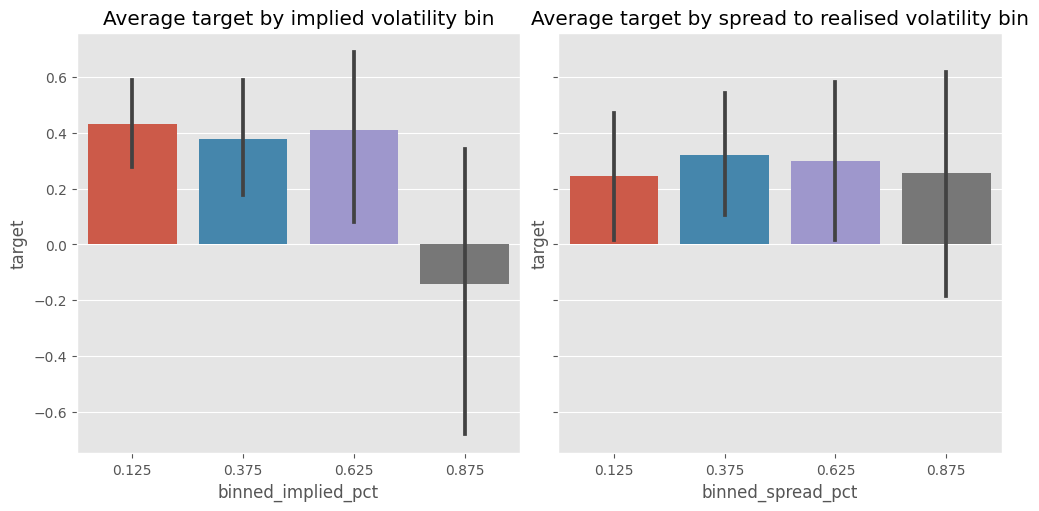

In [10]:
bins = np.linspace(0, 1, 5)
labels = bins[:-1] + np.diff(bins)/2
agg_values = pd.DataFrame(y_train_flat, columns=['target'])
agg_values['binned_implied_pct'] = pd.cut(X_train_flat['pct_implied_atm'], bins, labels=labels, include_lowest=True)
agg_values['binned_spread_pct'] = pd.cut(X_train_flat['pct_spread_realised_ewm'], bins, labels=labels, include_lowest=True)
fig, ax = plt.subplots(1,2, sharey=True, figsize=(10,5), constrained_layout=True)
sns.barplot(x='binned_implied_pct', y='target', data=agg_values, ax=ax[0])
sns.barplot(x='binned_spread_pct', y='target', data=agg_values, ax=ax[1])
ax[0].set_title('Average target by implied volatility bin')
ax[1].set_title('Average target by spread to realised volatility bin')
fig.show()

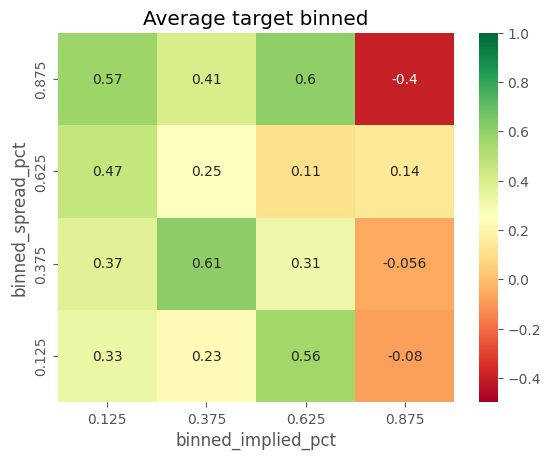

In [11]:
ax = sns.heatmap(pd.pivot_table(
    agg_values.astype(float),
    values='target',
    columns= agg_values['binned_implied_pct'], index=agg_values['binned_spread_pct'], aggfunc=np.mean),
    cmap='RdYlGn', vmin=-0.5, vmax=1, annot=True)
ax.invert_yaxis()
ax.set_title('Average target binned')
plt.show()

In [12]:
threshold = 0.5
labels_train = (y_train_flat > threshold).astype(int)
print("Train Set positive lables: %d out of %d" % (labels_train.sum(), len(labels_train)))
labels_test = (y_test_flat > threshold).astype(int)

Train Set positive lables: 786 out of 1540


In [13]:
fb_score = make_scorer(fbeta_score, beta=(1/4))

In [14]:
tscv = TimeSeriesSplit(n_splits=5, gap=1)
pipeline_cv = Pipeline([
    ('svm', SVC())  # SVM classifier
])
param_grid_svm = [{'svm__C':[0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 2.5, 5, 10.0],
                   'svm__kernel':['rbf'],
                   'svm__gamma':["scale", "auto", 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1]}]
grid_search = GridSearchCV(pipeline_cv, param_grid_svm, n_jobs=-1, cv=tscv, scoring=fb_score)
grid_search.fit(X_train_flat, labels_train)
grid_search.best_params_

{'svm__C': 2.5, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}

Tuned model:
              precision    recall  f1-score   support

           0       0.53      0.39      0.45       754
           1       0.53      0.67      0.60       786

    accuracy                           0.53      1540
   macro avg       0.53      0.53      0.52      1540
weighted avg       0.53      0.53      0.52      1540



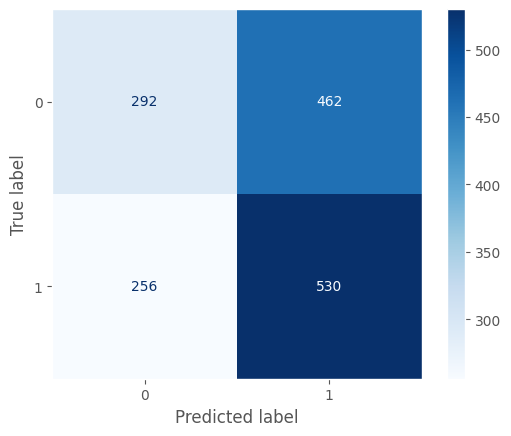

In [15]:
pipeline = Pipeline([
    ('svm', SVC(C=2.5, gamma='auto', kernel='rbf'))  # SVM classifier
])

pipeline.fit(X_train_flat, labels_train)

print("Tuned model:")
print(classification_report(labels_train, pipeline.predict(X_train_flat)))
disp = ConfusionMatrixDisplay.from_estimator(
        pipeline,
        X_train_flat,
        labels_train,
        display_labels=pipeline.classes_,
        cmap=plt.cm.Blues
    )
disp.ax_.grid(False)

In [16]:
des_vector = pipeline.decision_function(X_train_flat)
des_th = np.percentile(des_vector[des_vector > 0], 25)

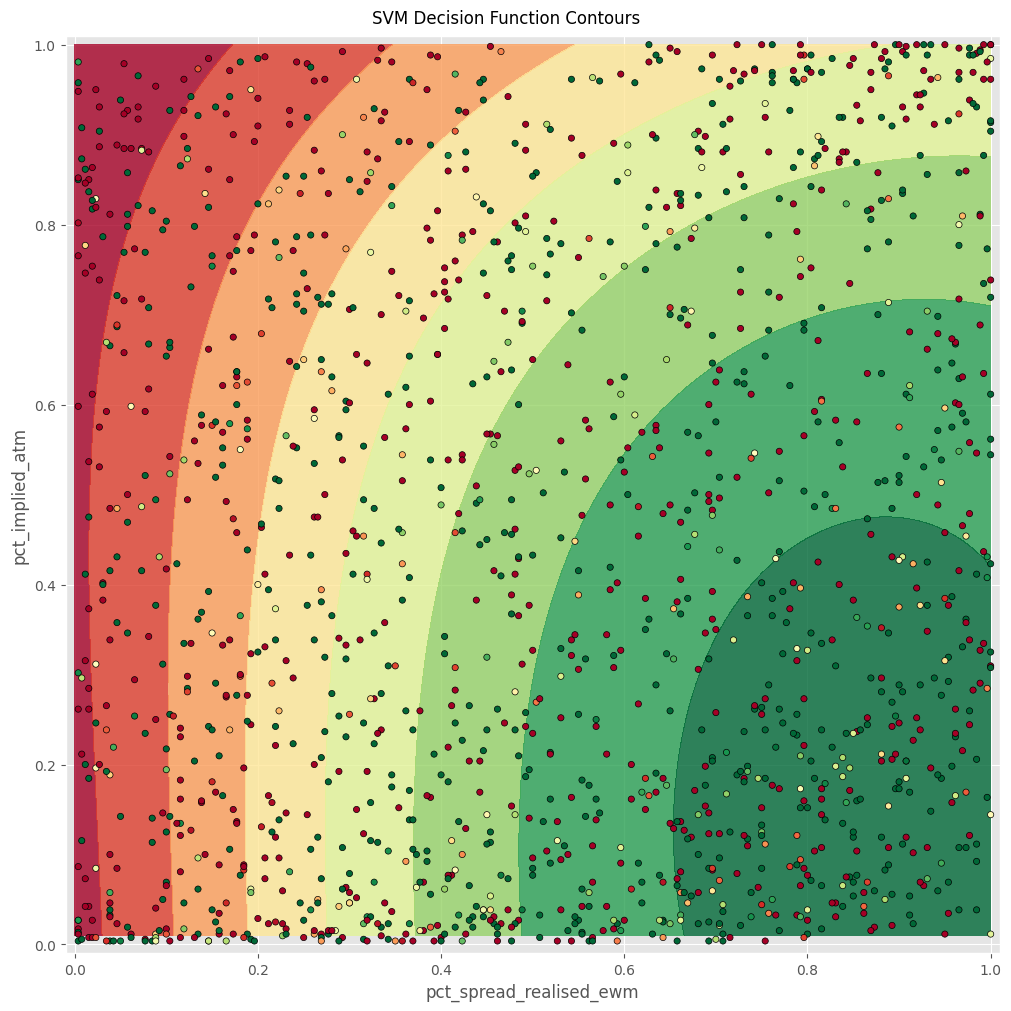

In [17]:
xx, yy = np.meshgrid(np.arange(0,1.01,0.01), np.arange(0.01,1.01,0.01))
fig, ax = plt.subplots(figsize=(10,10), constrained_layout=True)
plot_contours(ax, pipeline, xx, yy, cmap='RdYlGn', vmin=-1, vmax=1, alpha=0.8)
ax.scatter(X_train_flat.iloc[:,0], X_train_flat.iloc[:,1],
        c=y_train_flat, cmap='RdYlGn', vmin=0, vmax=1, s=20, edgecolors='k')
plt.xlim(-0.01,1.01)
plt.ylim(-0.01,1.01)
ax.xaxis.set_label_text(X_train_flat.columns[0])
ax.yaxis.set_label_text(X_train_flat.columns[1])
fig.suptitle('SVM Decision Function Contours')
fig.show()

In [18]:
print(classification_report(labels_test, pipeline.decision_function(X_test_flat)>des_th))

              precision    recall  f1-score   support

           0       0.60      0.55      0.58       217
           1       0.48      0.52      0.50       168

    accuracy                           0.54       385
   macro avg       0.54      0.54      0.54       385
weighted avg       0.55      0.54      0.54       385



         Sharpe Ratio
Naive            0.71
SVM              1.12
Uniform          0.46
LS               0.74


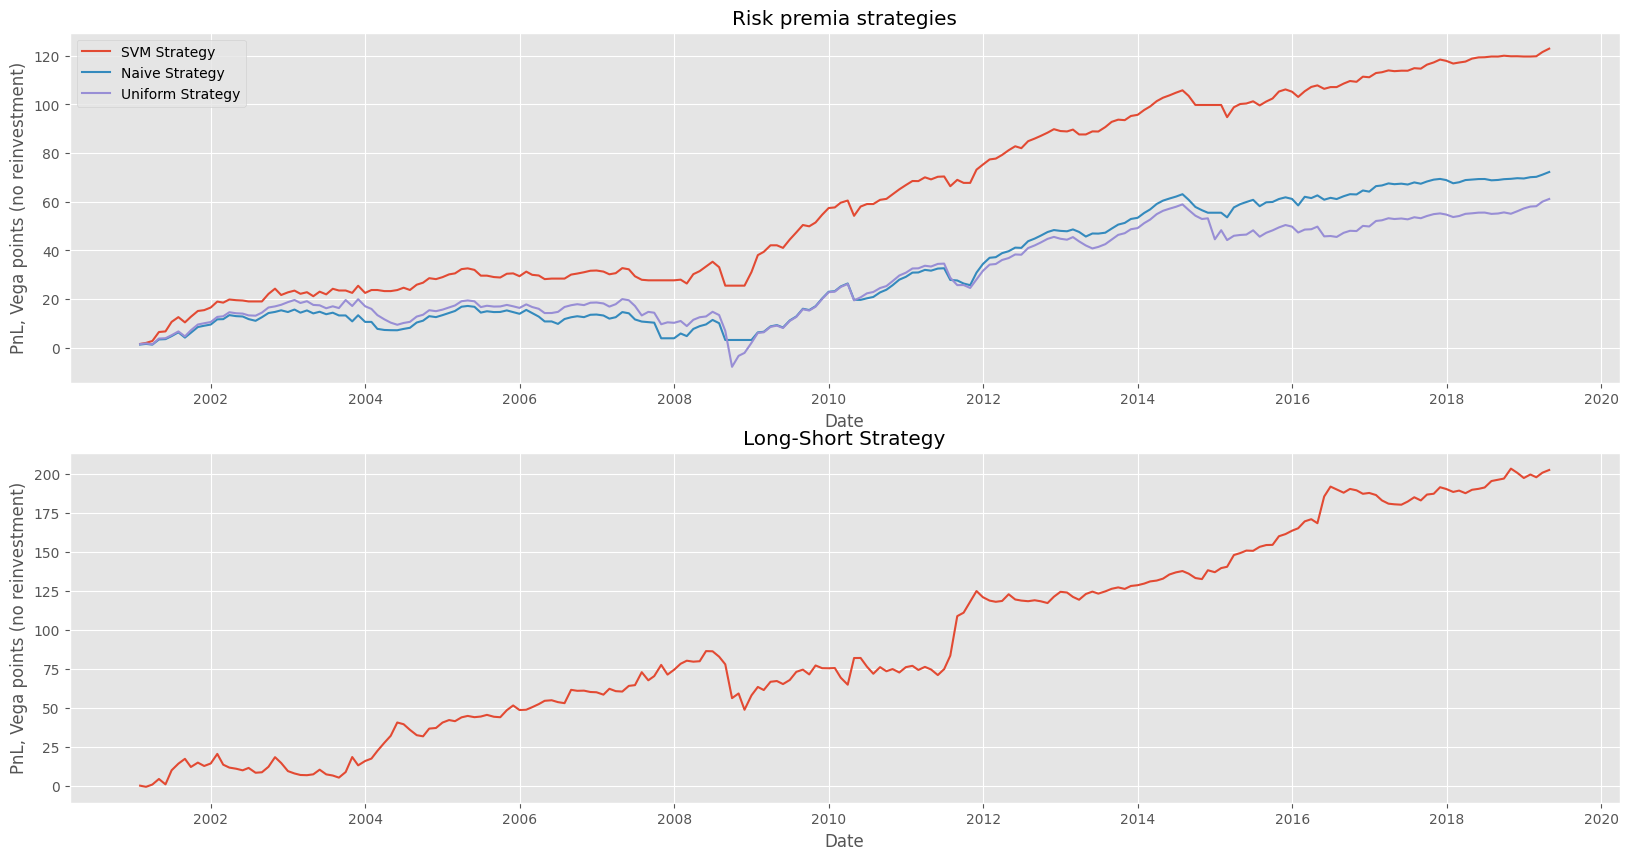

In [19]:
selected_features = X_train_flat.columns
features_data = pd.concat([features.filter(regex='^'+f) for f in selected_features], axis=1).loc[y_train.index]
signal_ml = pd.DataFrame(index=y_train.index, columns=ccies)
signal_naive = pd.DataFrame(index=y_train.index, columns=ccies)
des_f = pd.DataFrame(index=y_train.index, columns=ccies)
for ccy in ccies:
    c = [f + '_' + ccy for f in selected_features]
    signal_ml[ccy] = (pipeline.decision_function(features_data[c].to_numpy()) > des_th).astype(int)
    signal_naive[ccy] = (features_data['pct_implied_atm_'+ccy] <= 0.75).astype(int)
    des_f[ccy] = pipeline.decision_function(features_data[c].to_numpy())
pos_ml = signal_ml.div(signal_ml.sum(axis=1), axis=0).fillna(0)
pnl_ml = (pos_ml * y_train).sum(axis=1)
pnl_uniform = (y_train.mean(axis=1))
pos_naive = signal_naive.div(signal_naive.sum(axis=1), axis=0).fillna(0)
pnl_naive = (pos_naive * y_train).sum(axis=1)
ls_position = (des_f.rank(axis=1) >= (len(des_f.columns) - 1)).astype(int) - (des_f.rank(axis=1) <= 2).astype(int)
ls_pnl = (ls_position * y_train).sum(axis=1)
sharpe = pd.DataFrame(index=['Naive', 'SVM', 'Uniform', 'LS'], columns=['Sharpe Ratio'])
sharpe['Sharpe Ratio'] = [np.sqrt(12)*pnl.mean()/pnl.std() for pnl in [pnl_naive, pnl_ml, pnl_uniform, ls_pnl]]
with pd.option_context('display.float_format', '{:,.2f}'.format):
        print(sharpe)

fig, ax = plt.subplots(2,1, figsize=(20,10))
ax[0].plot(pnl_ml.cumsum(), label='SVM Strategy')
ax[0].plot(pnl_naive.cumsum(), label='Naive Strategy')
ax[0].plot(pnl_uniform.cumsum(), label='Uniform Strategy')
ax[0].set_title('Risk premia strategies')
ax[0].legend()
ax[0].xaxis.set_label_text('Date')
ax[0].yaxis.set_label_text('PnL, Vega points (no reinvestment)')
ax[1].set_title('Long-Short Strategy')
ax[1].plot(ls_pnl.cumsum(), label='Long-Short SVM Strategy')
ax[1].xaxis.set_label_text('Date')
ax[1].yaxis.set_label_text('PnL, Vega points (no reinvestment)')
fig.show()

         Sharpe Ratio
Naive           -0.06
SVM              1.52
Uniform         -0.03
LS               0.69


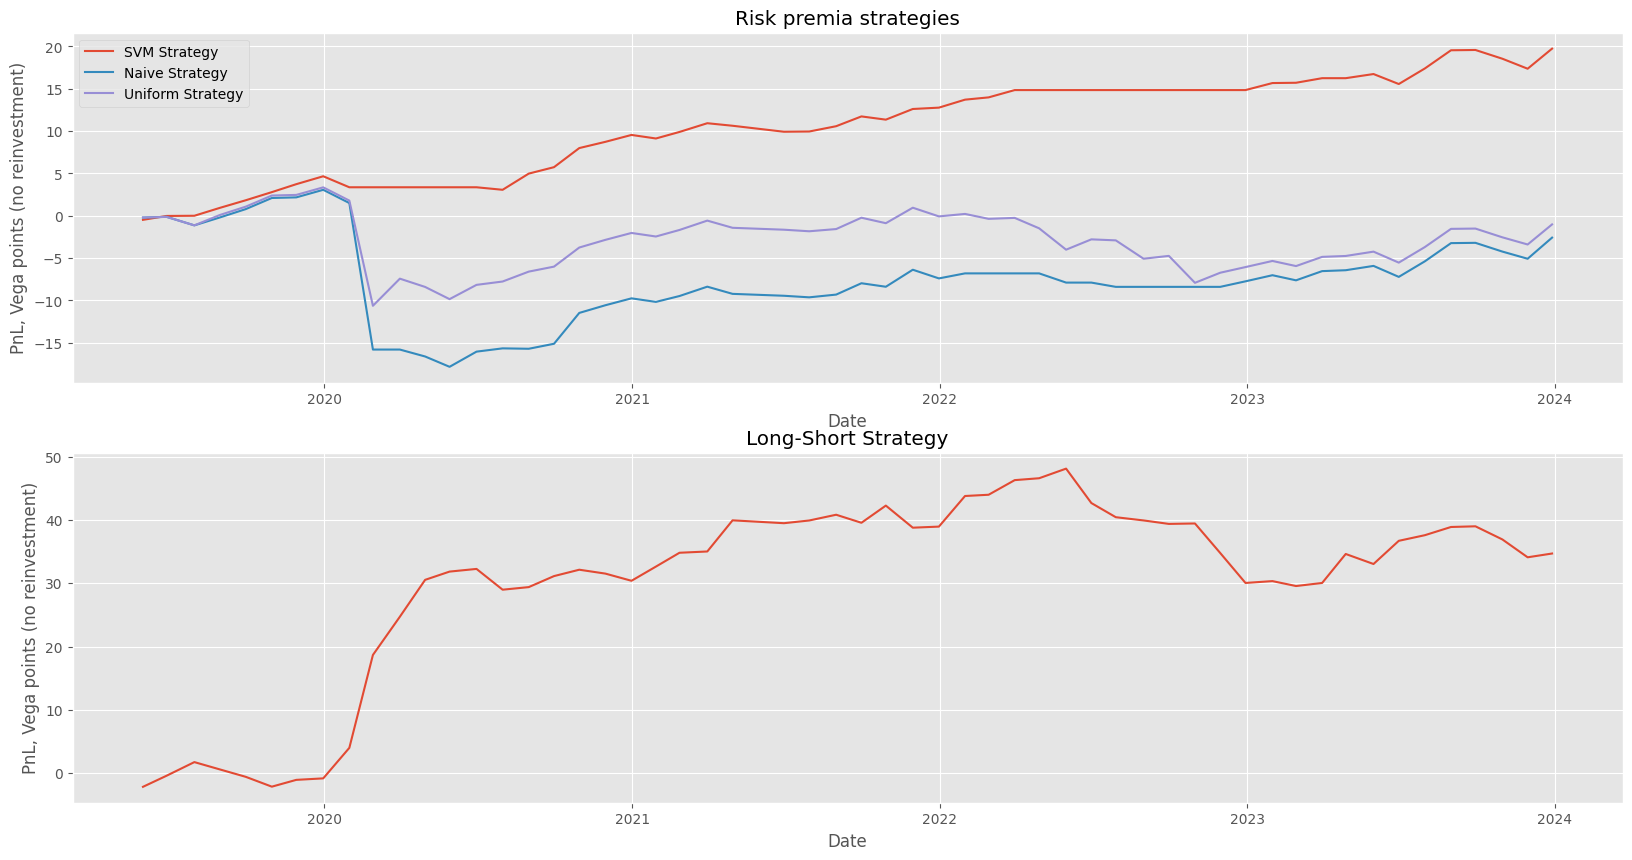

In [20]:
features_data = pd.concat([features.filter(regex='^'+f) for f in selected_features], axis=1).shift(0).loc[y_test.index]
signal_ml = pd.DataFrame(index=y_test.index, columns=ccies)
signal_naive = pd.DataFrame(index=y_test.index, columns=ccies)
des_f = pd.DataFrame(index=y_test.index, columns=ccies)
for ccy in ccies:
    c = [f + '_' + ccy for f in selected_features]
    signal_ml[ccy] = (pipeline.decision_function(features_data[c].to_numpy()) > des_th).astype(int)
    signal_naive[ccy] = (features_data['pct_implied_atm_'+ccy] <= 0.75).astype(int)
    des_f[ccy] = pipeline.decision_function(features_data[c].to_numpy())
pos_ml = signal_ml.div(signal_ml.sum(axis=1), axis=0).fillna(0)
pnl_ml = (pos_ml * y_test).sum(axis=1)
pnl_uniform = (y_test.mean(axis=1))
pos_naive = signal_naive.div(signal_naive.sum(axis=1), axis=0).fillna(0)
pnl_naive = (pos_naive * y_test).sum(axis=1)
ls_position = (des_f.rank(axis=1) >= (len(des_f.columns) - 1)).astype(int) - (des_f.rank(axis=1) <= 2).astype(int)
ls_pnl = (ls_position * y_test).sum(axis=1)
sharpe = pd.DataFrame(index=['Naive', 'SVM', 'Uniform', 'LS'], columns=['Sharpe Ratio'])
sharpe['Sharpe Ratio'] = [np.sqrt(12)*pnl.mean()/pnl.std() for pnl in [pnl_naive, pnl_ml, pnl_uniform, ls_pnl]]
with pd.option_context('display.float_format', '{:,.2f}'.format):
        print(sharpe)

fig, ax = plt.subplots(2,1, figsize=(20,10))
ax[0].plot(pnl_ml.cumsum(), label='SVM Strategy')
ax[0].plot(pnl_naive.cumsum(), label='Naive Strategy')
ax[0].plot(pnl_uniform.cumsum(), label='Uniform Strategy')
ax[0].set_title('Risk premia strategies')
ax[0].legend()
ax[0].xaxis.set_label_text('Date')
ax[0].yaxis.set_label_text('PnL, Vega points (no reinvestment)')
ax[1].set_title('Long-Short Strategy')
ax[1].plot(ls_pnl.cumsum(), label='Long-Short SVM Strategy')
ax[1].xaxis.set_label_text('Date')
ax[1].yaxis.set_label_text('PnL, Vega points (no reinvestment)')
fig.show()

In [63]:
y = (implied_vol - 100 * realised_vol).dropna()
X = features.filter(regex='^pct').dropna() #.shift(1) #may go here or better later in backtest
idx = (X.index).intersection(y.index)
X, y = X.loc[idx], y.loc[idx]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train_flat = data_flat(X_train)
X_test_flat = data_flat(X_test)
y_train_flat = pd.Series(y_train[ccies].to_numpy().flatten(order='C'))
y_test_flat = pd.Series(y_test[ccies].to_numpy().flatten(order='C'))
print('Train Set: %s to %s' % (str(X_train.index[0].date()), str(X_train.index[-1].date())))
print('Test Set: %s to %s' % (str(X_test.index[0].date()), str(X_test.index[-1].date())))

threshold = 0.5
labels_train = (y_train_flat > threshold).astype(int)
print("Train Set positive lables: %d out of %d" % (labels_train.sum(), len(labels_train)))
labels_test = (y_test_flat > threshold).astype(int)


Train Set: 2001-01-31 to 2019-04-30
Test Set: 2019-05-31 to 2023-12-29
Train Set positive lables: 786 out of 1540


In [39]:
X_train_flat = X_train_flat.iloc[:,:-3]
X_test_flat = X_test_flat.iloc[:,:-3]

In [40]:
fs_model = RandomForestClassifier(n_estimators=500, max_depth=2, random_state=42)
fs_model.fit(X_train_flat, labels_train)

boruta = BorutaPy(estimator=fs_model, n_estimators = 'auto', random_state=42)
boruta.fit(np.array(X_train_flat), np.array(labels_train))
strong_support = X_train_flat.columns[boruta.support_].to_list()
weak_support = X_train_flat.columns[boruta.support_weak_].to_list()
print('Boruta Strong features:', strong_support)
print('Boruta Weak features:', weak_support)

Boruta Strong features: ['pct_spot_range', 'pct_realised_yz', 'pct_spread_realised_par', 'pct_spread_realised_ctc', 'pct_realised_gk', 'pct_realised_par']
Boruta Weak features: ['pct_realised_ctc', 'pct_spread_realised_gk', 'pct_realised_rs']


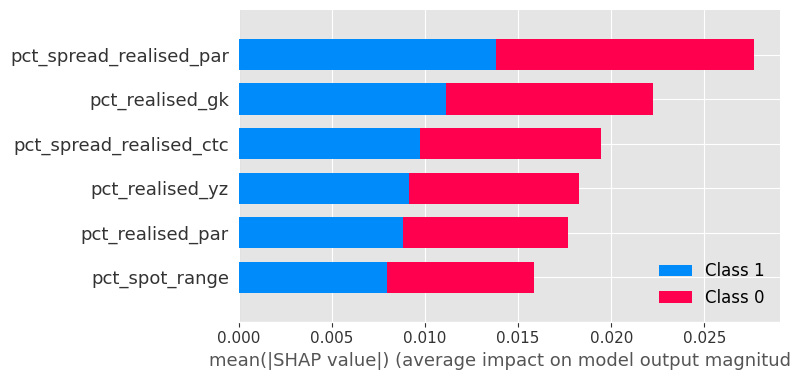

In [41]:
X_train_flat = X_train_flat[strong_support]
X_test_flat = X_test_flat[strong_support]

shap.initjs()
fs_model.fit(X_train_flat, labels_train)
explainer = shap.TreeExplainer(fs_model)
shap_values = explainer.shap_values(X_train_flat)
shap.summary_plot(shap_values, X_train_flat)

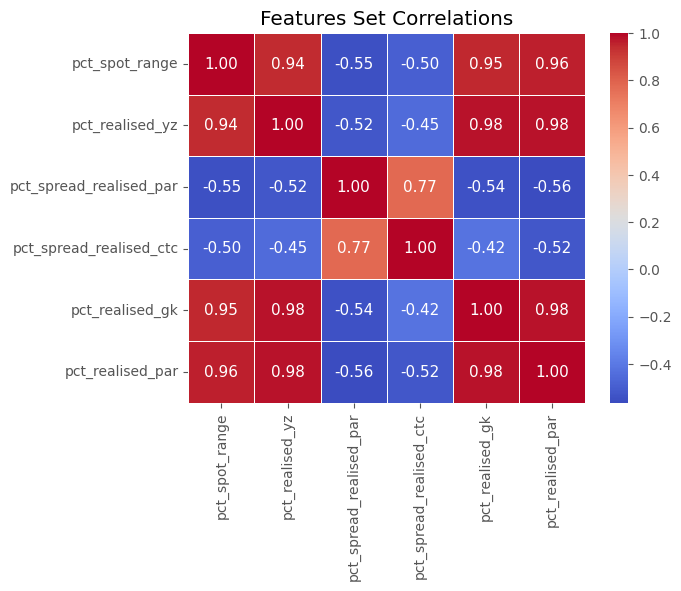

In [42]:
sns.heatmap(X_train_flat.corr(), 
            annot=True,  
            annot_kws={"size": 11}, 
            fmt=".2f", 
            linewidth=.5, 
            cmap="coolwarm", 
            cbar=True);

plt.title('Features Set Correlations');

In [43]:
X_train_flat.drop(columns=['pct_spot_range', 'pct_realised_par', 'pct_realised_yz', 'pct_spread_realised_ctc'], inplace=True)
X_test_flat.drop(columns=['pct_spot_range', 'pct_realised_par', 'pct_realised_yz', 'pct_spread_realised_ctc'], inplace=True)

In [45]:
models = [
    ('LR', LogisticRegression(n_jobs=-1)),
    ('SVM', SVC(C=2.5, gamma='auto', kernel='rbf')),
    ('KNN', KNeighborsClassifier()),
    ('CART', DecisionTreeClassifier()),
    ('RF', RandomForestClassifier(n_jobs=-1, n_estimators=500, max_depth=2, random_state=42)),
    ('AB', AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=10, random_state=42)),
    ('GBM', GradientBoostingClassifier(n_estimators=10, max_depth=1, random_state=42)),
    ('XGB', xgb.XGBClassifier(n_jobs=-1, n_estimators=10, max_depth=1, random_state=42))
]
tscv = TimeSeriesSplit(n_splits=5, gap=1)
for clf_name, clf in models:
    print(clf_name, cross_val_score(clf, X_train_flat, labels_train, cv=tscv, scoring=fb_score).mean())

LR 0.5517528571107816
SVM 0.5450688445471659
KNN 0.5127055387421163
CART 0.5139984668953816
RF 0.5344486311358331
AB 0.5084600162501636
GBM 0.5437041642312194
XGB 0.5362592244676051


In [46]:
tscv = TimeSeriesSplit(n_splits=5, gap=1)
pipeline_cv = Pipeline([
    ('svm', SVC())  # SVM classifier
])
param_grid_svm = [{'svm__C':[0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 2.5, 5, 10.0],
                   'svm__kernel':['rbf'],
                   'svm__gamma':["scale", "auto", 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1]}]
grid_search = GridSearchCV(pipeline_cv, param_grid_svm, n_jobs=-1, cv=tscv, scoring=fb_score)
grid_search.fit(X_train_flat, labels_train)
grid_search.best_params_

{'svm__C': 0.1, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}

Tuned model:
              precision    recall  f1-score   support

           0       0.56      0.45      0.50       754
           1       0.56      0.66      0.61       786

    accuracy                           0.56      1540
   macro avg       0.56      0.56      0.55      1540
weighted avg       0.56      0.56      0.55      1540



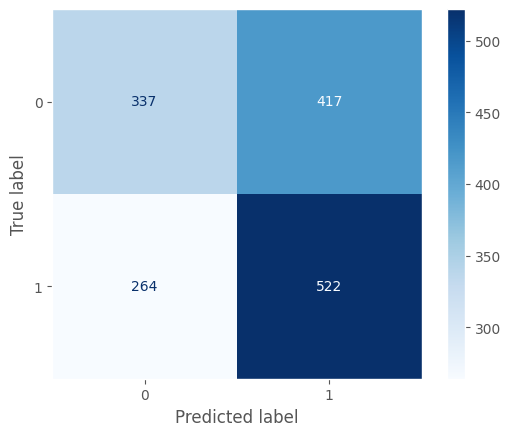

In [49]:
pipeline = Pipeline([
    ('svm', SVC(C=2.5, gamma='auto', kernel='rbf'))  # SVM classifier
])

pipeline.fit(X_train_flat, labels_train)

print("Tuned model:")
print(classification_report(labels_train, pipeline.predict(X_train_flat)))
disp = ConfusionMatrixDisplay.from_estimator(
        pipeline,
        X_train_flat,
        labels_train,
        display_labels=pipeline.classes_,
        cmap=plt.cm.Blues
    )
disp.ax_.grid(False)

In [50]:
des_vector = pipeline.decision_function(X_train_flat)
des_th = np.percentile(des_vector[des_vector > 0], 25)

print(classification_report(labels_test, pipeline.decision_function(X_test_flat)>des_th))

              precision    recall  f1-score   support

           0       0.53      0.50      0.51       217
           1       0.40      0.43      0.42       168

    accuracy                           0.47       385
   macro avg       0.47      0.47      0.47       385
weighted avg       0.47      0.47      0.47       385



In [51]:
param_grid = {
    'max_depth': [1],
    'learning_rate': [0.1, 0.2, 0.3, 0.5, 0.7, 1],
    'subsample': [0.5, 0.7, 1],
    'n_estimators': [5, 10, 20, 50, 70],
    'gamma': [0, 0.1, 1, 2, 5, 10, 15],
    'reg_lambda': [0, 1, 2, 3, 5],
    'reg_alpha': [0, 1, 2, 3, 5],
    'random_state': [42],
    'n_jobs': [-1]
}

xgb_clf = xgb.XGBClassifier()
grid_search = GridSearchCV(xgb_clf, param_grid, cv=tscv, scoring=fb_score)
grid_search.fit(X_train_flat, labels_train)
grid_search.best_params_

{'gamma': 0,
 'learning_rate': 1,
 'max_depth': 1,
 'n_estimators': 5,
 'n_jobs': -1,
 'random_state': 42,
 'reg_alpha': 3,
 'reg_lambda': 3,
 'subsample': 0.7}

In [52]:
xgb_clf = xgb.XGBClassifier(**grid_search.best_params_)
#xgb_clf = xgb.XGBClassifier(n_jobs=-1, n_estimators=5, max_depth=2, random_state=42,
#                            learning_rate=100, subsample=0.7, gamma=5, colsample_bytree=1,
#                            reg_lambda=2, reg_alpha=1)
xgb_clf.fit(X_train_flat, labels_train)
print(cross_val_score(xgb_clf, X_train_flat, labels_train, cv=tscv, scoring=fb_score))
print(classification_report(labels_train, xgb_clf.predict(X_train_flat)))

[0.47465636 0.5787234  0.66212269 0.67193676 0.46348588]
              precision    recall  f1-score   support

           0       0.57      0.42      0.49       754
           1       0.55      0.69      0.61       786

    accuracy                           0.56      1540
   macro avg       0.56      0.56      0.55      1540
weighted avg       0.56      0.56      0.55      1540



In [58]:
des_vector = xgb_clf.predict_proba(X_train_flat)[:,1]
des_th = np.percentile(des_vector, 75)

print(des_th)
print(classification_report(labels_test, xgb_clf.predict_proba(X_test_flat)[:,1]>0.55))

0.5833274722099304
              precision    recall  f1-score   support

           0       0.57      0.71      0.64       217
           1       0.46      0.31      0.37       168

    accuracy                           0.54       385
   macro avg       0.51      0.51      0.50       385
weighted avg       0.52      0.54      0.52       385



In [53]:
print(classification_report(labels_test, xgb_clf.predict(X_test_flat)))

              precision    recall  f1-score   support

           0       0.55      0.41      0.47       217
           1       0.42      0.57      0.48       168

    accuracy                           0.48       385
   macro avg       0.49      0.49      0.48       385
weighted avg       0.49      0.48      0.47       385



         Sharpe Ratio
GBM              1.44
Uniform          0.46
LS               0.28


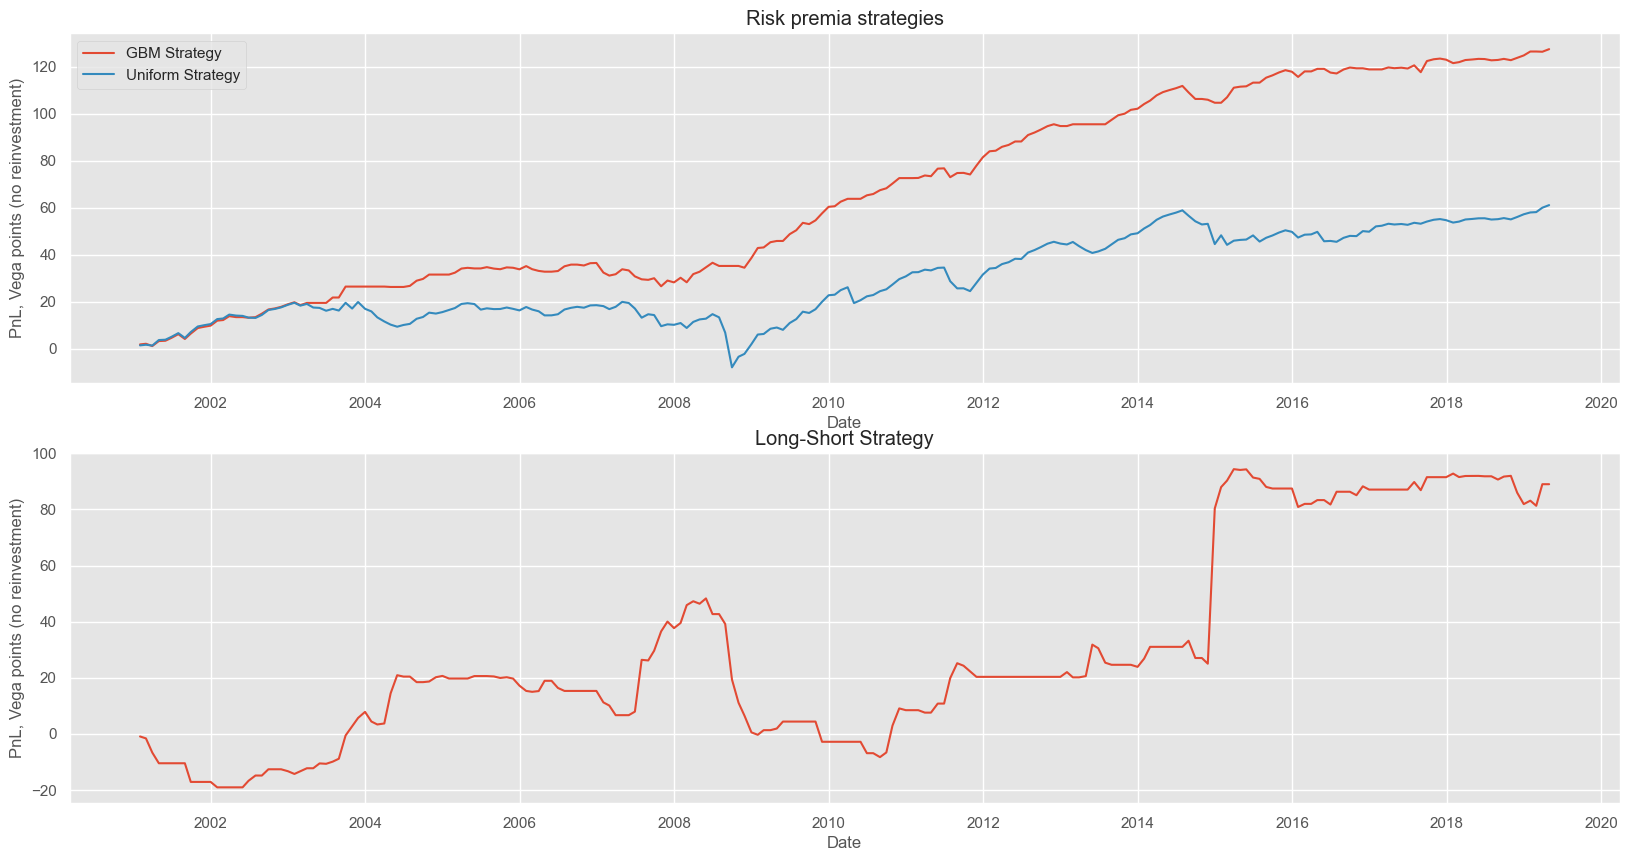

In [286]:
selected_features = X_train_flat.columns
features_data = pd.concat([features.filter(regex='^'+f) for f in selected_features], axis=1).loc[y_train.index]
signal_ml = pd.DataFrame(index=y_train.index, columns=ccies)
signal_naive = pd.DataFrame(index=y_train.index, columns=ccies)
des_f = pd.DataFrame(index=y_train.index, columns=ccies)
for ccy in ccies:
    c = [f + '_' + ccy for f in selected_features[:-2]] +[f + '_all' for f in selected_features[-2:]]
    signal_ml[ccy] = (xgb_clf.predict(features_data[c].to_numpy())).astype(int)
    des_f[ccy] = xgb_clf.predict_proba(features_data[c].to_numpy())[:,1]
pos_ml = signal_ml.div(signal_ml.sum(axis=1), axis=0).fillna(0)
pnl_ml = (pos_ml * y_train).sum(axis=1)
pnl_uniform = (y_train.mean(axis=1))
ls_position = (des_f.rank(axis=1) >= (len(des_f.columns) - 1)).astype(int) - (des_f.rank(axis=1) <= 2).astype(int)
ls_pnl = (ls_position * y_train).sum(axis=1)
sharpe = pd.DataFrame(index=['GBM', 'Uniform', 'LS'], columns=['Sharpe Ratio'])
sharpe['Sharpe Ratio'] = [np.sqrt(12)*pnl.mean()/pnl.std() for pnl in [pnl_ml, pnl_uniform, ls_pnl]]
with pd.option_context('display.float_format', '{:,.2f}'.format):
        print(sharpe)

fig, ax = plt.subplots(2,1, figsize=(20,10))
ax[0].plot(pnl_ml.cumsum(), label='GBM Strategy')
ax[0].plot(pnl_uniform.cumsum(), label='Uniform Strategy')
ax[0].set_title('Risk premia strategies')
ax[0].legend()
ax[0].xaxis.set_label_text('Date')
ax[0].yaxis.set_label_text('PnL, Vega points (no reinvestment)')
ax[1].set_title('Long-Short Strategy')
ax[1].plot(ls_pnl.cumsum(), label='Long-Short GBM Strategy')
ax[1].xaxis.set_label_text('Date')
ax[1].yaxis.set_label_text('PnL, Vega points (no reinvestment)')
fig.show()

         Sharpe Ratio
GBM             -0.25
Uniform         -0.03
LS               0.35


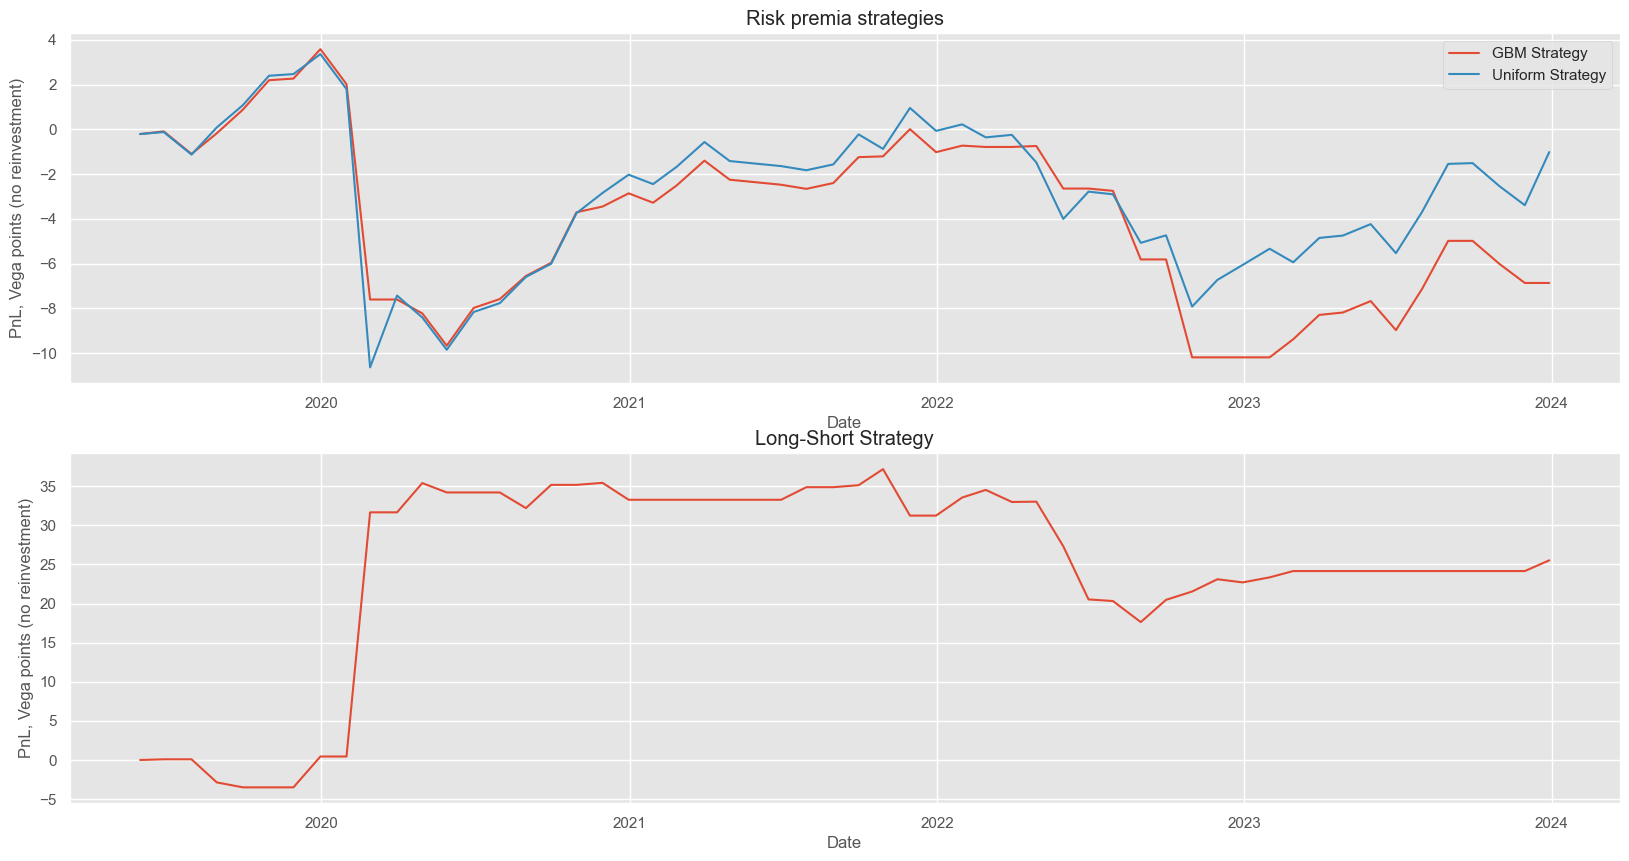

In [290]:
selected_features = X_test_flat.columns
features_data = pd.concat([features.filter(regex='^'+f) for f in selected_features], axis=1).loc[y_test.index]
signal_ml = pd.DataFrame(index=y_test.index, columns=ccies)
signal_naive = pd.DataFrame(index=y_test.index, columns=ccies)
des_f = pd.DataFrame(index=y_test.index, columns=ccies)
for ccy in ccies:
    c = [f + '_' + ccy for f in selected_features[:-2]] +[f + '_all' for f in selected_features[-2:]]
    signal_ml[ccy] = (xgb_clf.predict(features_data[c].to_numpy())).astype(int)
    des_f[ccy] = xgb_clf.predict_proba(features_data[c].to_numpy())[:,1]
pos_ml = signal_ml.div(signal_ml.sum(axis=1), axis=0).fillna(0)
pnl_ml = (pos_ml * y_test).sum(axis=1)
pnl_uniform = (y_test.mean(axis=1))
ls_position = (des_f.rank(axis=1) >= (len(des_f.columns) - 1)).astype(int) - (des_f.rank(axis=1) <= 2).astype(int)
ls_pnl = (ls_position * y_test).sum(axis=1)
sharpe = pd.DataFrame(index=['GBM', 'Uniform', 'LS'], columns=['Sharpe Ratio'])
sharpe['Sharpe Ratio'] = [np.sqrt(12)*pnl.mean()/pnl.std() for pnl in [pnl_ml, pnl_uniform, ls_pnl]]
with pd.option_context('display.float_format', '{:,.2f}'.format):
        print(sharpe)

fig, ax = plt.subplots(2,1, figsize=(20,10))
ax[0].plot(pnl_ml.cumsum(), label='GBM Strategy')
ax[0].plot(pnl_uniform.cumsum(), label='Uniform Strategy')
ax[0].set_title('Risk premia strategies')
ax[0].legend()
ax[0].xaxis.set_label_text('Date')
ax[0].yaxis.set_label_text('PnL, Vega points (no reinvestment)')
ax[1].set_title('Long-Short Strategy')
ax[1].plot(ls_pnl.cumsum(), label='Long-Short GBM Strategy')
ax[1].xaxis.set_label_text('Date')
ax[1].yaxis.set_label_text('PnL, Vega points (no reinvestment)')
fig.show()

In [288]:
features_data.head()

,pct_spread_realised_par_EUR,pct_spread_realised_par_JPY,pct_spread_realised_par_GBP,pct_spread_realised_par_CAD,pct_spread_realised_par_AUD,pct_spread_realised_par_NZD,pct_spread_realised_par_CHF,pct_realised_gk_EUR,pct_realised_gk_JPY,pct_realised_gk_GBP,pct_realised_gk_CAD,pct_realised_gk_AUD,pct_realised_gk_NZD,pct_realised_gk_CHF,pct_VIX Index_all,pct_CVIX1I Index_all
2019-05-31,0.950000,0.796154,0.065385,0.507692,0.923077,0.976923,0.400000,0.026923,0.330769,0.588462,0.011538,0.023077,0.015385,0.157692,0.753846,0.123077
2019-06-28,0.438462,0.665385,0.069231,0.680769,0.784615,0.342308,0.103846,0.292308,0.423077,0.076923,0.046154,0.026923,0.142308,0.876923,0.480769,0.180769
2019-07-31,0.638462,0.157692,0.057692,0.557692,0.561538,0.603846,0.415385,0.057692,0.203846,0.515385,0.038462,0.023077,0.111538,0.161538,0.619231,0.046154
2019-08-30,0.742308,0.084615,0.803846,0.465385,0.430769,0.261538,0.157692,0.357692,0.915385,0.703846,0.361538,0.653846,0.846154,0.938462,0.730769,0.753846
2019-09-30,0.219231,0.888462,0.419231,0.980769,0.984615,0.684615,0.561538,0.630769,0.411538,0.942308,0.003846,0.061538,0.319231,0.434615,0.530769,0.492308


In [59]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 2.5, 5, 10.0]}
lr_clf = LogisticRegression(n_jobs=-1, solver='liblinear')
grid_search_lr = GridSearchCV(lr_clf, param_grid, cv=tscv, scoring=fb_score)
grid_search_lr.fit(X_train_flat, labels_train)
grid_search_lr.best_params_

{'C': 0.05, 'penalty': 'l2'}

In [60]:
lr_clf = LogisticRegression(n_jobs=-1, solver='liblinear', **grid_search_lr.best_params_)
lr_clf.fit(X_train_flat, labels_train)
print(cross_val_score(lr_clf, X_train_flat, labels_train, cv=tscv, scoring=fb_score))
print(classification_report(labels_train, lr_clf.predict(X_train_flat)))

[0.45223112 0.62385321 0.61594203 0.63892617 0.47781917]
              precision    recall  f1-score   support

           0       0.55      0.46      0.50       754
           1       0.55      0.65      0.60       786

    accuracy                           0.55      1540
   macro avg       0.55      0.55      0.55      1540
weighted avg       0.55      0.55      0.55      1540



In [61]:
print(classification_report(labels_test, lr_clf.predict(X_test_flat)))

              precision    recall  f1-score   support

           0       0.47      0.31      0.37       217
           1       0.38      0.55      0.45       168

    accuracy                           0.41       385
   macro avg       0.42      0.43      0.41       385
weighted avg       0.43      0.41      0.41       385



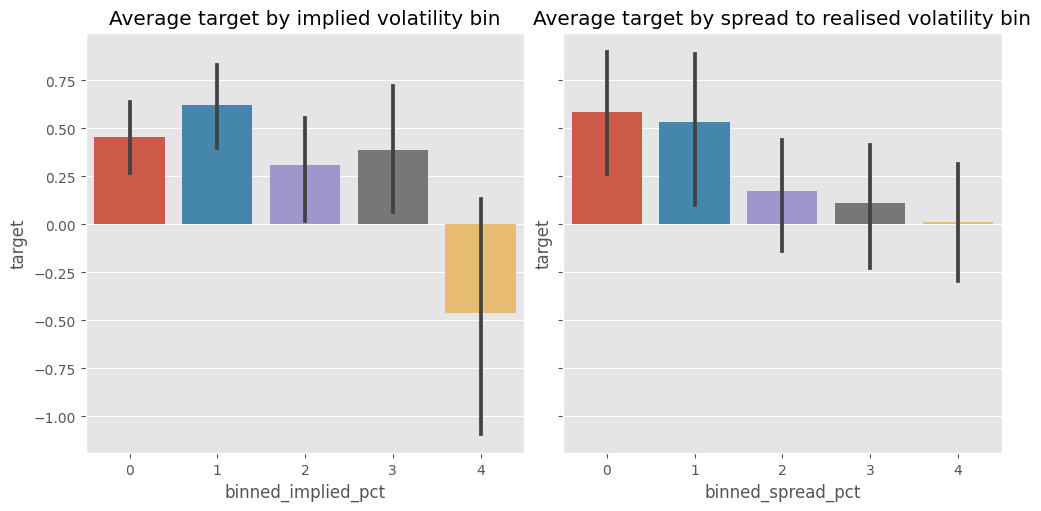

In [64]:
vol_level = ['pct_realised_rs', 'pct_realised_gk',
       'pct_implied_atm',
       'pct_realised_par', 'pct_realised_yz',
       'pct_realised_ewm',
       'pct_realised_ctc',
       ]#'pct_MOVE Index', 'pct_VIX Index', 'pct_CVIX1I Index']
#vol_level = ['pct_implied_atm', 'pct_MOVE Index', 'pct_VIX Index', 'pct_CVIX1I Index']
spread_level = ['pct_spread_realised_ewm', 'pct_spread_realised_ctc',
         'pct_spread_realised_par', 'pct_spread_realised_gk',
         'pct_spread_realised_rs', 'pct_spread_realised_yz']
X1_train = X_train_flat[vol_level]
X2_train = X_train_flat[spread_level]
pca_features_train = pd.DataFrame(index=X_train_flat.index)
pca_features_test = pd.DataFrame(index=X_test_flat.index)

cov = X1_train.cov()
eig_vals, eig_vecs = np.linalg.eig(cov)
permutation = np.argsort(-eig_vals)
eig_vals = eig_vals[permutation]
eig_vecs = eig_vecs[:, permutation]

level_weigts = eig_vecs[:,0]
pca_features_train['Level'] = X1_train.dot(level_weigts)
pca_features_test['Level'] = X_test_flat[vol_level].dot(level_weigts)


cov = X2_train.cov()
eig_vals, eig_vecs = np.linalg.eig(cov)
permutation = np.argsort(-eig_vals)
eig_vals = eig_vals[permutation]
eig_vecs = eig_vecs[:, permutation]

spread_weigts = eig_vecs[:,0]
pca_features_train['Spread '] = X2_train.dot(spread_weigts)
pca_features_test['Spread '] = X_test_flat[spread_level].dot(spread_weigts)

agg_values = pd.DataFrame(y_train_flat, columns=['target'])
agg_values['binned_implied_pct'] = pd.cut(pca_features_train['Level'], bins=5, labels=False, include_lowest=True)
agg_values['binned_spread_pct'] = pd.cut(pca_features_train['Spread '], bins=5, labels=False, include_lowest=True)
fig, ax = plt.subplots(1,2, sharey=True, figsize=(10,5), constrained_layout=True)
sns.barplot(x='binned_implied_pct', y='target', data=agg_values, ax=ax[0])
sns.barplot(x='binned_spread_pct', y='target', data=agg_values, ax=ax[1])
ax[0].set_title('Average target by implied volatility bin')
ax[1].set_title('Average target by spread to realised volatility bin')
fig.show()

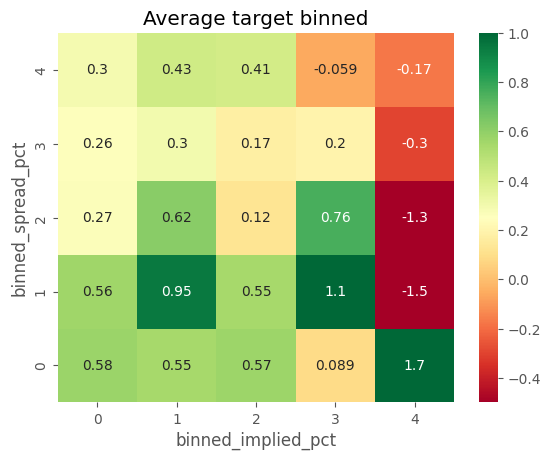

In [65]:
ax = sns.heatmap(pd.pivot_table(
    agg_values.astype(float),
    values='target',
    columns= agg_values['binned_implied_pct'], index=agg_values['binned_spread_pct'], aggfunc=np.mean),
    cmap='RdYlGn', vmin=-0.5, vmax=1, annot=True)
ax.invert_yaxis()
ax.set_title('Average target binned')
plt.show()

In [66]:
tscv = TimeSeriesSplit(n_splits=5, gap=1)
pipeline_cv = Pipeline([
    ('svm', SVC())  # SVM classifier
])
param_grid_svm = [{'svm__C':[0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 2.5, 5, 10.0],
                   'svm__kernel':['rbf'],
                   'svm__gamma':["scale", "auto", 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1]}]
grid_search = GridSearchCV(pipeline_cv, param_grid_svm, n_jobs=-1, cv=tscv, scoring=fb_score)
grid_search.fit(pca_features_train, labels_train)
grid_search.best_params_

{'svm__C': 0.5, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}

Tuned model:
              precision    recall  f1-score   support

           0       0.54      0.50      0.52       754
           1       0.55      0.60      0.58       786

    accuracy                           0.55      1540
   macro avg       0.55      0.55      0.55      1540
weighted avg       0.55      0.55      0.55      1540



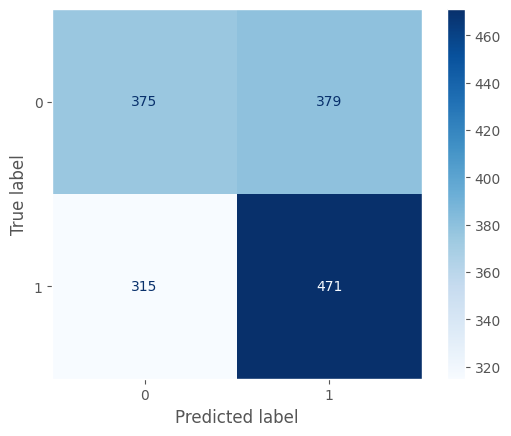

In [71]:
pipeline = Pipeline([
    ('svm', SVC(C=2.5, gamma='auto', kernel='rbf'))  # SVM classifier
])

pipeline.fit(pca_features_train, labels_train)

print("Tuned model:")
print(classification_report(labels_train, pipeline.predict(pca_features_train)))
disp = ConfusionMatrixDisplay.from_estimator(
        pipeline,
        pca_features_train,
        labels_train,
        display_labels=pipeline.classes_,
        cmap=plt.cm.Blues
    )
disp.ax_.grid(False)

In [72]:
print(classification_report(labels_test, pipeline.predict(pca_features_test)))

              precision    recall  f1-score   support

           0       0.54      0.41      0.47       217
           1       0.41      0.54      0.47       168

    accuracy                           0.47       385
   macro avg       0.48      0.48      0.47       385
weighted avg       0.48      0.47      0.47       385



In [74]:
des_vector = pipeline.decision_function(pca_features_train)
des_th = np.percentile(des_vector[des_vector > 0], 35)

print(classification_report(labels_test, pipeline.decision_function(pca_features_test)>des_th))

              precision    recall  f1-score   support

           0       0.54      0.61      0.57       217
           1       0.39      0.32      0.35       168

    accuracy                           0.49       385
   macro avg       0.46      0.47      0.46       385
weighted avg       0.47      0.49      0.48       385



         Sharpe Ratio
Naive            0.71
SVM              0.88
Uniform          0.46
LS               0.72


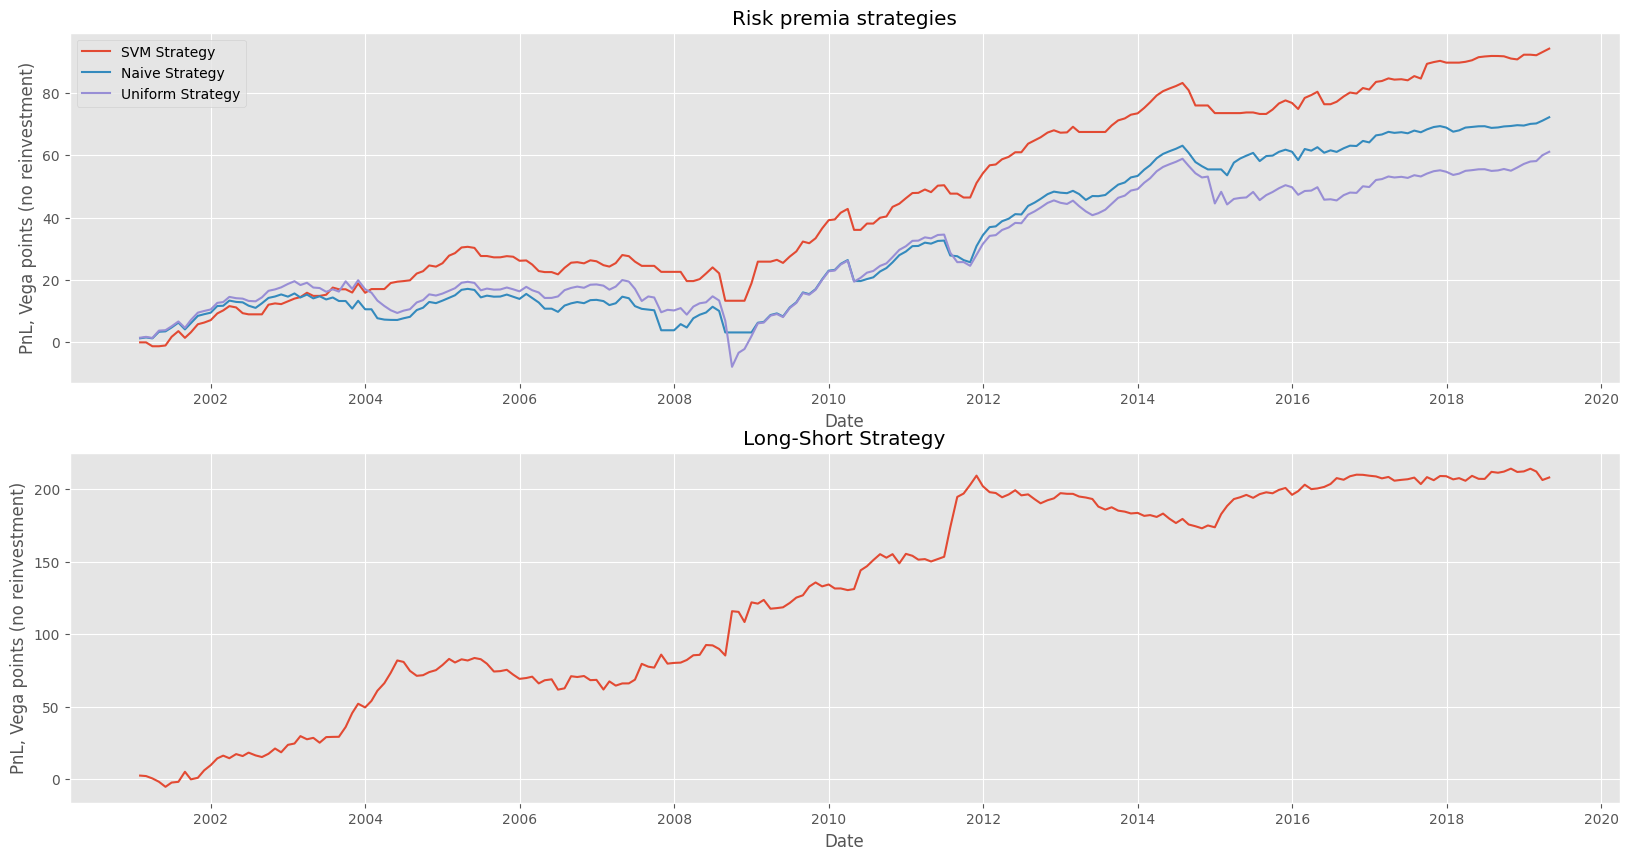

In [88]:
selected_features = vol_level + spread_level
features_data = pd.concat([features.filter(regex='^'+f) for f in selected_features], axis=1).loc[y_train.index]
signal_ml = pd.DataFrame(index=y_train.index, columns=ccies)
signal_naive = pd.DataFrame(index=y_train.index, columns=ccies)
des_f = pd.DataFrame(index=y_train.index, columns=ccies)
for ccy in ccies:
    c1 = [f + '_' + ccy for f in vol_level[:-3]] + [f + '_all' for f in vol_level[-3:]]
    c2 = [f + '_' + ccy for f in spread_level]
    ml_input = pd.concat([features_data[c1].dot(level_weigts), features_data[c2].dot(spread_weigts)], axis=1)
    signal_ml[ccy] = (pipeline.decision_function(ml_input.to_numpy()) > des_th).astype(int)
    signal_naive[ccy] = (features_data['pct_implied_atm_'+ccy] <= 0.75).astype(int)
    des_f[ccy] = pipeline.decision_function(ml_input.to_numpy())
pos_ml = signal_ml.div(signal_ml.sum(axis=1), axis=0).fillna(0)
pnl_ml = (pos_ml * y_train).sum(axis=1)
pnl_uniform = (y_train.mean(axis=1))
pos_naive = signal_naive.div(signal_naive.sum(axis=1), axis=0).fillna(0)
pnl_naive = (pos_naive * y_train).sum(axis=1)
ls_position = (des_f.rank(axis=1) >= (len(des_f.columns) - 1)).astype(int) - (des_f.rank(axis=1) <= 2).astype(int)
ls_pnl = (ls_position * y_train).sum(axis=1)
sharpe = pd.DataFrame(index=['Naive', 'SVM', 'Uniform', 'LS'], columns=['Sharpe Ratio'])
sharpe['Sharpe Ratio'] = [np.sqrt(12)*pnl.mean()/pnl.std() for pnl in [pnl_naive, pnl_ml, pnl_uniform, ls_pnl]]
with pd.option_context('display.float_format', '{:,.2f}'.format):
        print(sharpe)

fig, ax = plt.subplots(2,1, figsize=(20,10))
ax[0].plot(pnl_ml.cumsum(), label='SVM Strategy')
ax[0].plot(pnl_naive.cumsum(), label='Naive Strategy')
ax[0].plot(pnl_uniform.cumsum(), label='Uniform Strategy')
ax[0].set_title('Risk premia strategies')
ax[0].legend()
ax[0].xaxis.set_label_text('Date')
ax[0].yaxis.set_label_text('PnL, Vega points (no reinvestment)')
ax[1].set_title('Long-Short Strategy')
ax[1].plot(ls_pnl.cumsum(), label='Long-Short SVM Strategy')
ax[1].xaxis.set_label_text('Date')
ax[1].yaxis.set_label_text('PnL, Vega points (no reinvestment)')
fig.show()

In [66]:
fs = SelectKBest(score_func=f_classif)
fit = fs.fit(X_train_flat,labels_train)
features_p = pd.Series(index=X_train_flat.columns, data=fit.pvalues_)
#X_train_flat.drop(features_p[features_p > 0.05].index, axis=1, inplace=True)
features_p.sort_values().head(15)

pct_realised_gk            0.000229
pct_spread_realised_par    0.000350
pct_realised_par           0.000366
pct_realised_yz            0.000480
pct_realised_rs            0.000545
pct_spread_realised_ctc    0.001148
pct_spot_range             0.001152
pct_CVIX1I Index           0.001392
pct_realised_ctc           0.001600
pct_spread_realised_gk     0.001813
pct_spread_realised_yz     0.002345
pct_realised_ewm           0.003772
pct_spread_realised_rs     0.007828
pct_spread_realised_ewm    0.031027
pct_implied_atm            0.095129
dtype: float64

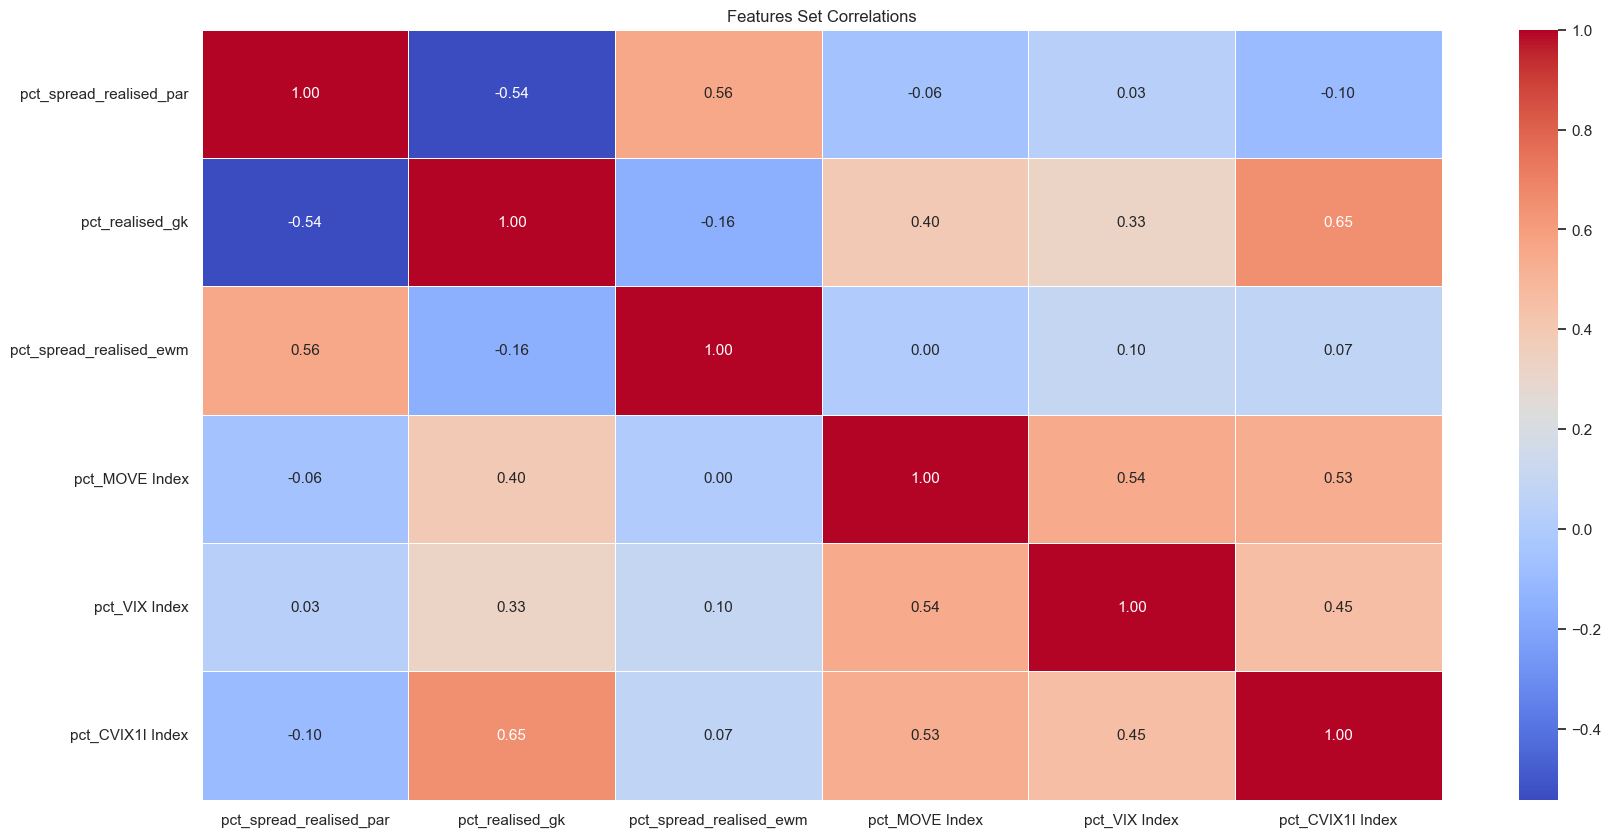

In [67]:
features_to_drop = []
features_corr = X_train_flat.corr()
for i in features_corr[(features_corr > 0.75) & (features_corr < 1)].\
unstack().dropna().sort_values(ascending=False).index:
    if features_p[i[0]] > features_p[i[1]]:
        features_to_drop.append(i[0])
    else:
        features_to_drop.append(i[1])
X_train_flat.drop(set(features_to_drop), axis=1, inplace=True)
sns.set(rc={'figure.figsize': (20, 10)})

sns.heatmap(X_train_flat.corr(), 
            annot=True,  
            annot_kws={"size": 11}, 
            fmt=".2f", 
            linewidth=.5, 
            cmap="coolwarm", 
            cbar=True);

plt.title('Features Set Correlations');

In [162]:
# spot check the algorithms
models = []
models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
#Ensable Models 
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier(n_jobs=-1, n_estimators=500, max_depth=2, random_state=42)))

tscv = TimeSeriesSplit(n_splits=5, gap=1)
for clf_name, clf in models:
    print(clf_name, cross_val_score(clf, X_train_flat, labels_train, cv=tscv, scoring=fb_score).mean())


LR 0.5633715388859637
KNN 0.5206628608431287
CART 0.5279465081231286
AB 0.5413825266471083
GBM 0.5320004512727452
RF 0.5502733775632638


In [97]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=10,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
print(cross_val_score(ada_clf, X_train_flat, labels_train, cv=tscv, scoring=fb_score).mean())

0.5320754756426755


In [103]:
gbm_clf = GradientBoostingClassifier(n_estimators=10, learning_rate=0.15, max_depth=1, random_state=42)
print(cross_val_score(gbm_clf, X_train_flat, labels_train, cv=tscv, scoring=fb_score).mean())

0.5337921481886154


In [78]:
X_train_flat.columns

Index(['pct_spread_realised_par', 'pct_realised_gk', 'pct_spread_realised_ewm',
       'pct_MOVE Index', 'pct_VIX Index', 'pct_CVIX1I Index'],
      dtype='object')

In [37]:
tscv = TimeSeriesSplit(n_splits=5, gap=1)
param_grid = {"n_estimators":[10, 100, 500],
              "max_depth":[2, 3, 4, 5]}

fs_model = GridSearchCV(RandomForestClassifier(random_state=42), 
                        param_grid, n_jobs=-1, cv=tscv, scoring=fb_score)
fs_model.fit(X_train_flat, labels_train)
fs_model.best_params_

{'max_depth': 2, 'n_estimators': 500}

In [157]:
fs_model = RandomForestClassifier(n_estimators=500, max_depth=2, random_state=42)
fs_model.fit(X_train_flat, labels_train)

boruta = BorutaPy(estimator=fs_model, n_estimators = 'auto', random_state=42)
boruta.fit(np.array(X_train_flat), np.array(labels_train))
strong_support = X_train_flat.columns[boruta.support_].to_list()
weak_support = X_train_flat.columns[boruta.support_weak_].to_list()
print('Boruta Strong features:', strong_support)
print('Boruta Weak features:', weak_support)

Boruta Strong features: ['pct_realised_par', 'pct_spread_realised_par', 'pct_realised_yz', 'pct_realised_gk', 'pct_VIX Index', 'pct_CVIX1I Index']
Boruta Weak features: ['pct_realised_ctc', 'pct_realised_rs', 'pct_spot_range', 'pct_spread_realised_ctc', 'pct_spread_realised_gk', 'pct_MOVE Index']


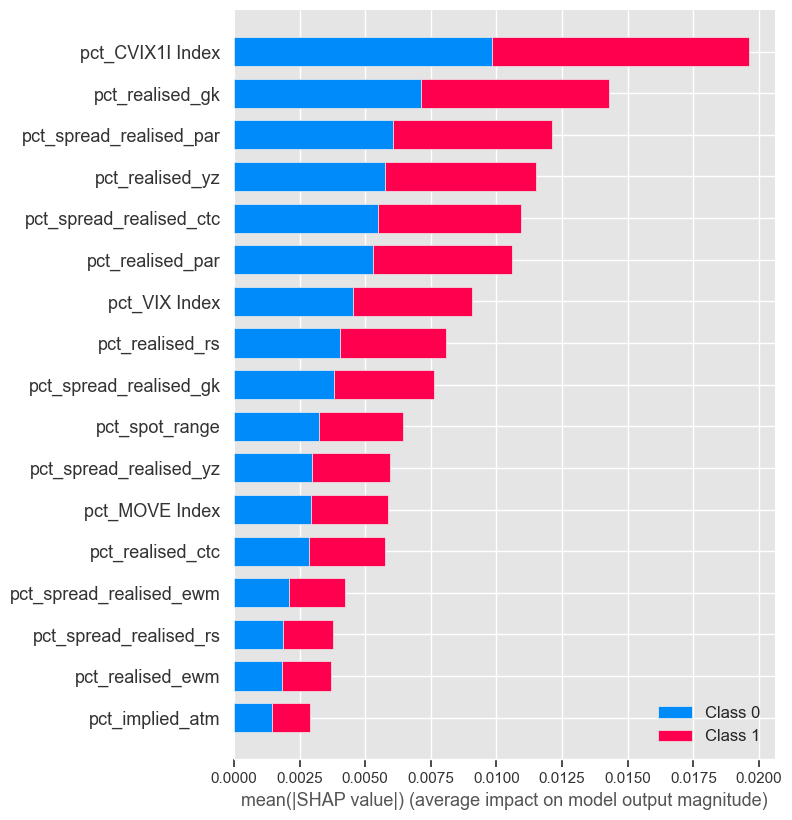

In [158]:
shap.initjs()
fs_model.fit(X_train_flat, labels_train)
explainer = shap.TreeExplainer(fs_model)
shap_values = explainer.shap_values(X_train_flat)
shap.summary_plot(shap_values, X_train_flat)

In [160]:
X_train_flat = X_train_flat[['pct_CVIX1I Index', 'pct_spread_realised_par', 'pct_realised_gk']]

In [161]:
clf = xgb.XGBClassifier(n_estimators=10, max_depth=1, random_state=42)
print(cross_val_score(clf, X_train_flat, labels_train, cv=tscv, scoring=fb_score).mean())

clf.fit(X_train_flat, labels_train)
print(classification_report(labels_train, clf.predict(X_train_flat)))

0.5591244052542484
              precision    recall  f1-score   support

           0       0.57      0.52      0.54       754
           1       0.58      0.63      0.60       786

    accuracy                           0.57      1540
   macro avg       0.57      0.57      0.57      1540
weighted avg       0.57      0.57      0.57      1540



In [141]:
print(classification_report(labels_test, clf.predict(X_test_flat[['pct_CVIX1I Index', 'pct_spread_realised_par']])))

              precision    recall  f1-score   support

           0       0.49      0.34      0.40       217
           1       0.39      0.54      0.45       168

    accuracy                           0.43       385
   macro avg       0.44      0.44      0.43       385
weighted avg       0.45      0.43      0.42       385



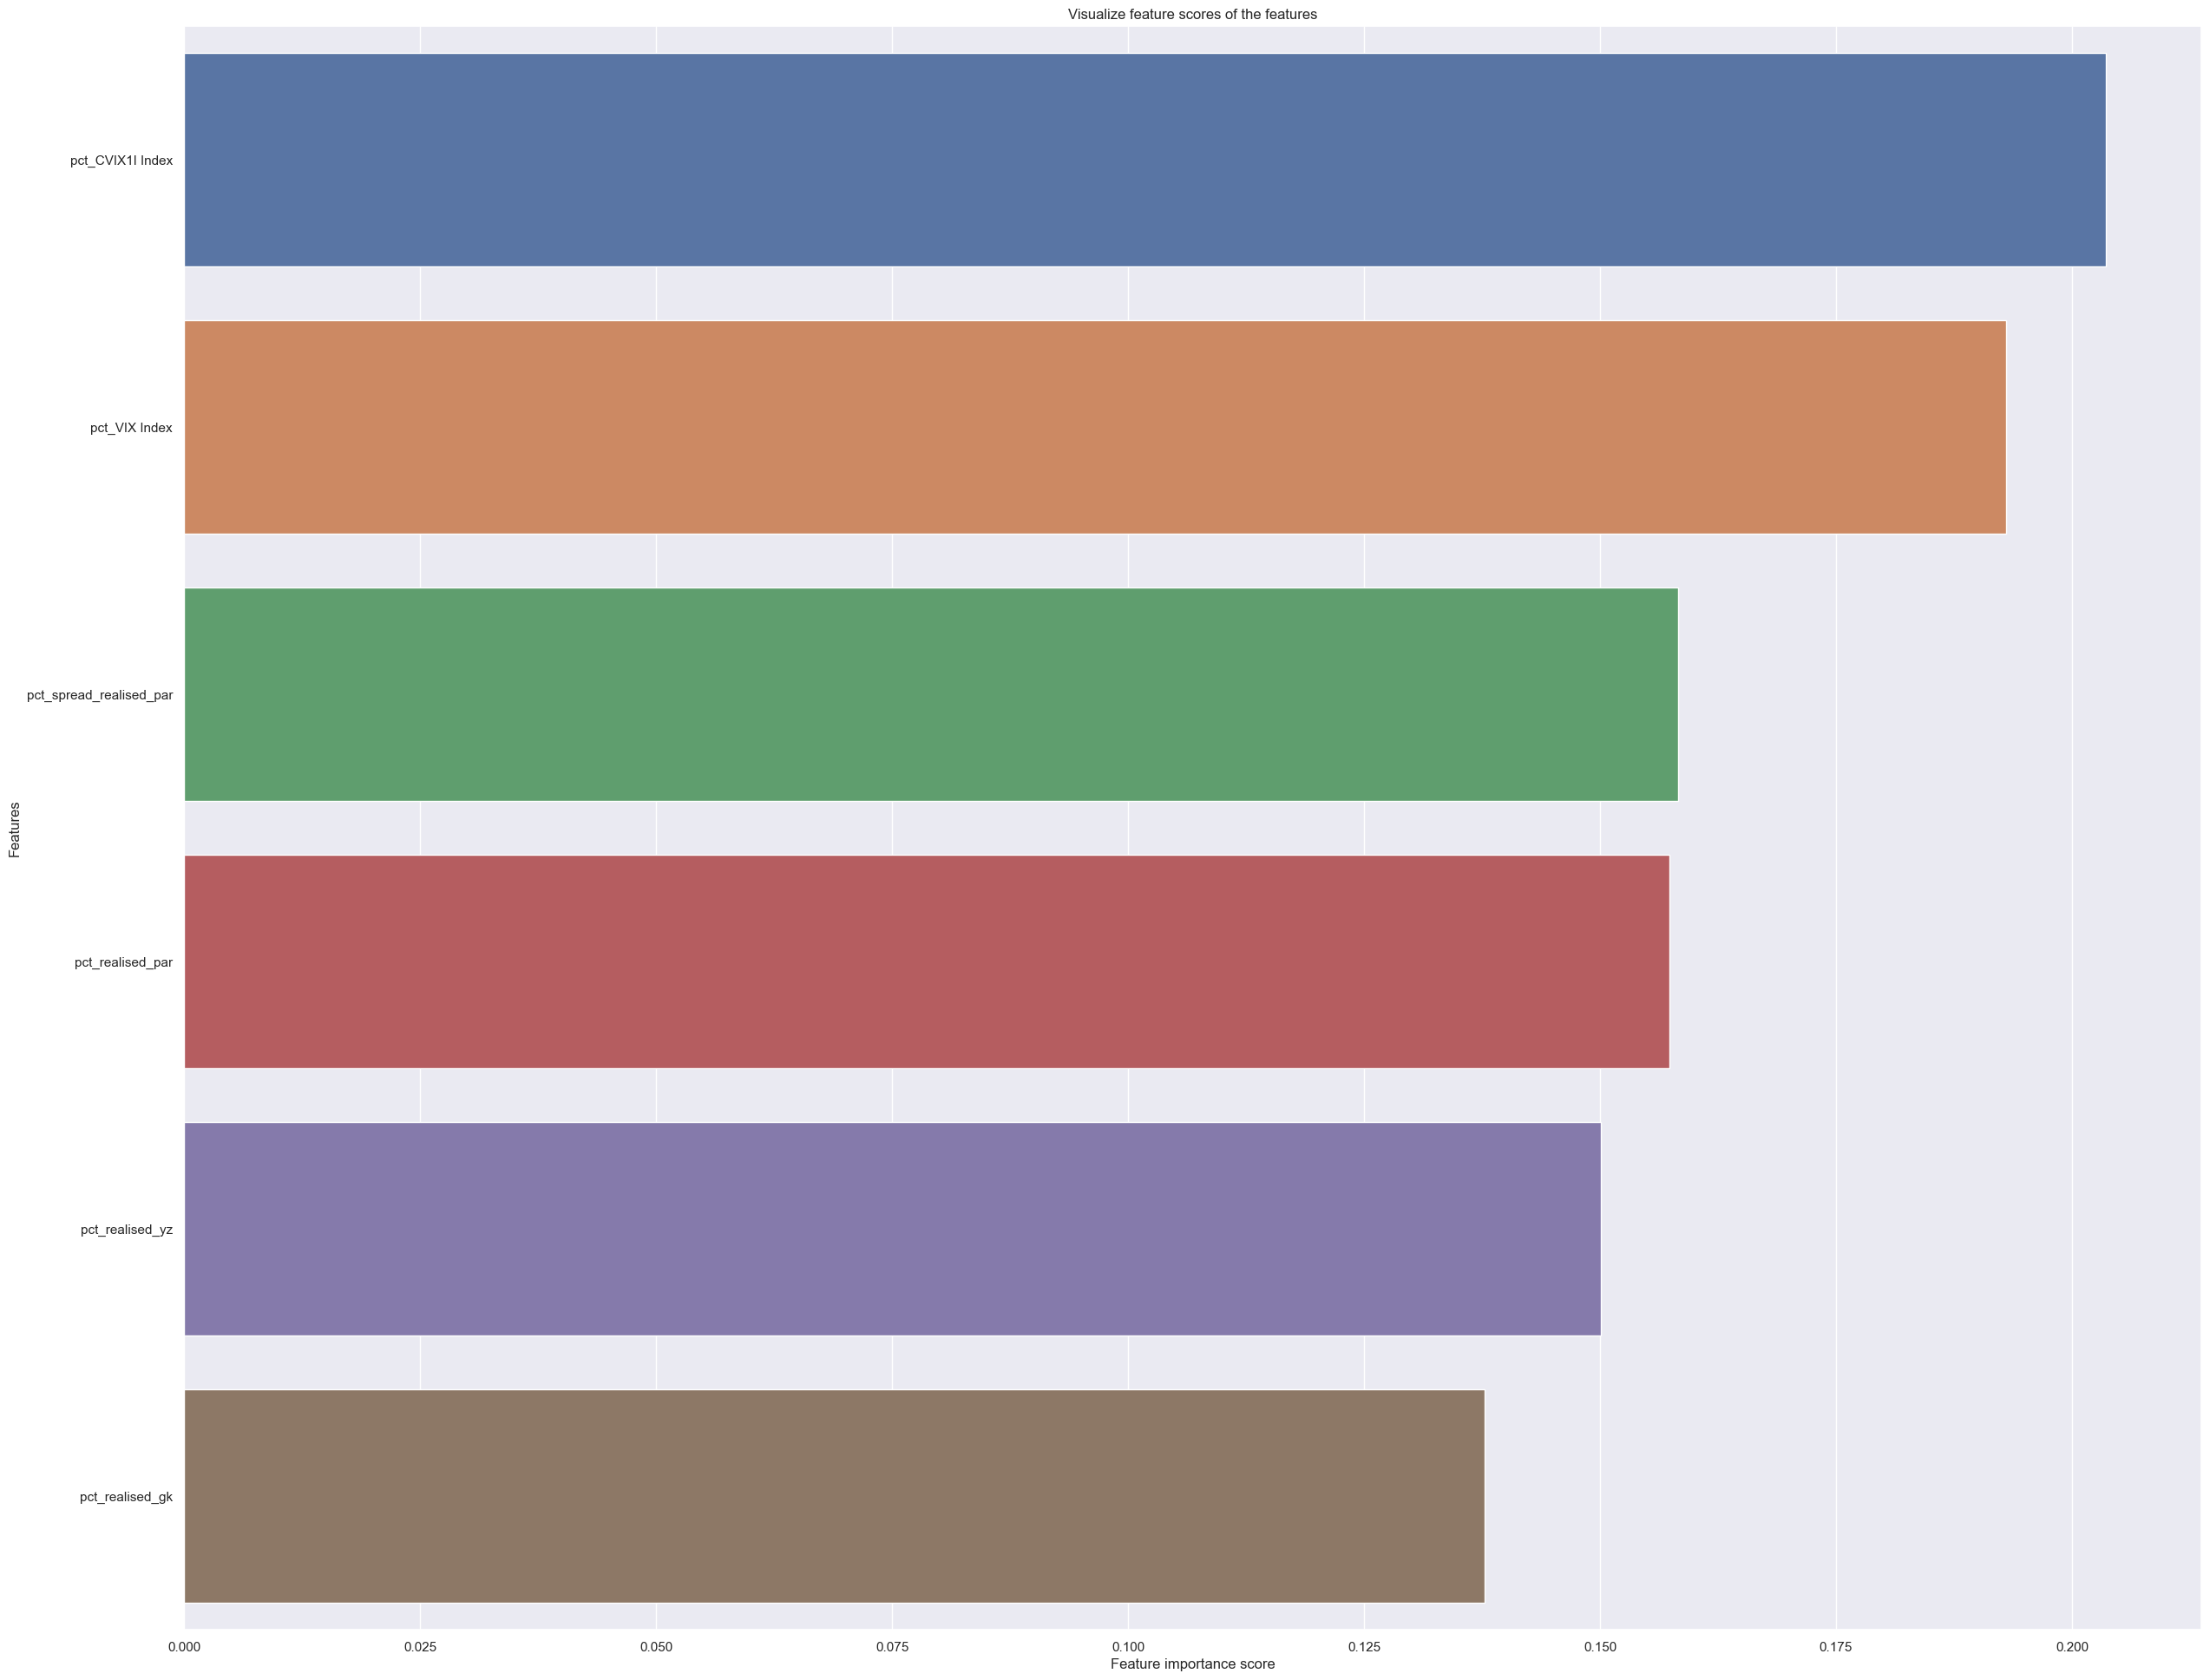

In [50]:
fs_model.fit(X_train_flat, labels_train)
feature_scores = pd.Series(fs_model.feature_importances_, index=X_train_flat.columns).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=feature_scores, y=feature_scores.index)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

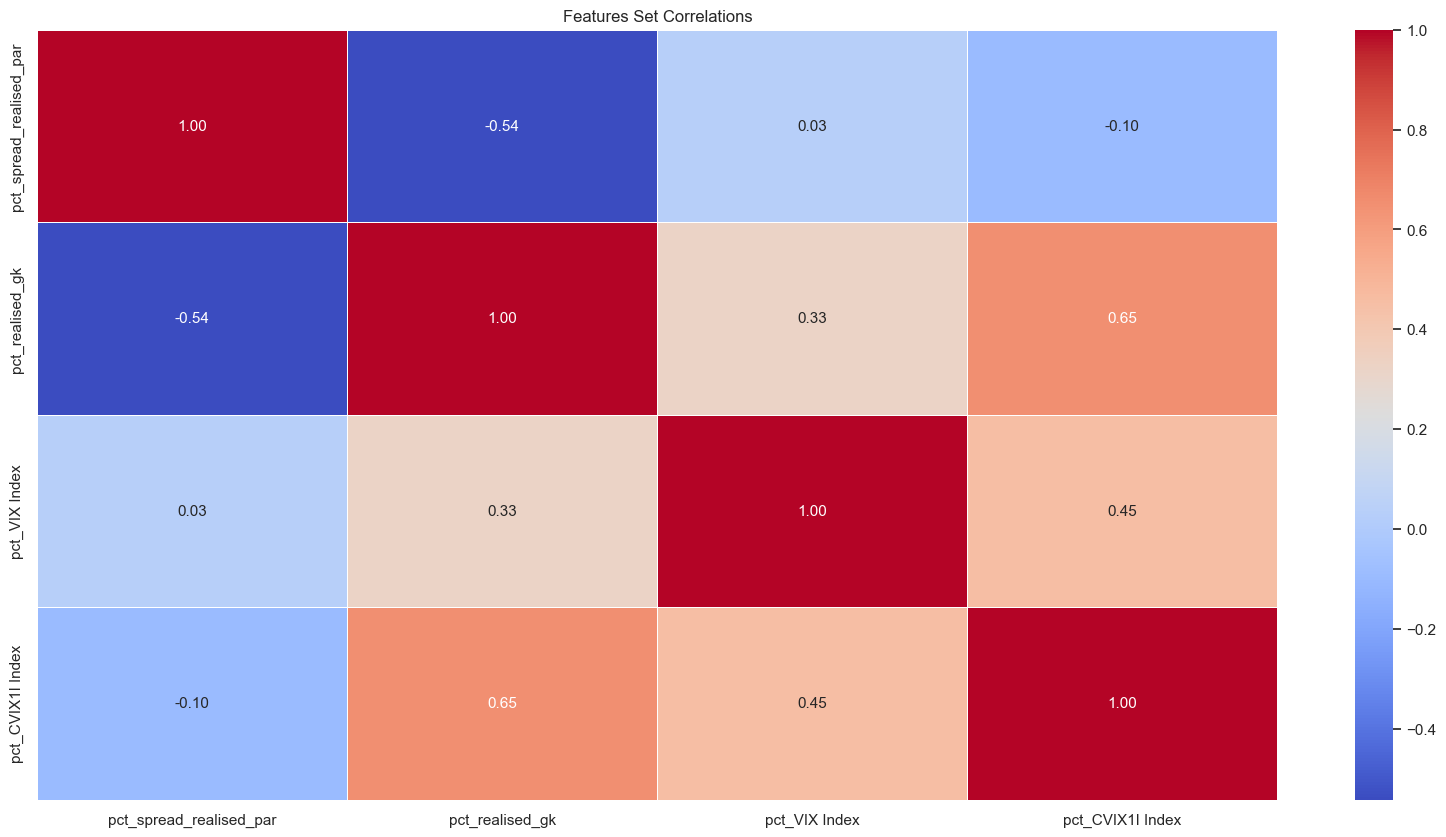

In [51]:
features_to_drop = []
features_corr = X_train_flat.corr()
for i in features_corr[(features_corr > 0.75) & (features_corr < 1)].\
unstack().dropna().sort_values(ascending=False).index:
    if feature_scores[i[0]] > feature_scores[i[1]]:
        features_to_drop.append(i[0])
    else:
        features_to_drop.append(i[1])
X_train_flat.drop(set(features_to_drop), axis=1, inplace=True)
sns.set(rc={'figure.figsize': (20, 10)})

sns.heatmap(X_train_flat.corr(), 
            annot=True,  
            annot_kws={"size": 11}, 
            fmt=".2f", 
            linewidth=.5, 
            cmap="coolwarm", 
            cbar=True);

plt.title('Features Set Correlations');

In [163]:
tscv = TimeSeriesSplit(n_splits=5, gap=1)
param_grid = {"n_estimators":[10, 100, 500],
              "max_depth":[2, 3, 4, 5]}

rf_model = GridSearchCV(RandomForestClassifier(random_state=42), 
                        param_grid, n_jobs=-1, cv=tscv, scoring=fb_score)
rf_model.fit(X_train_flat, labels_train)
rf_model.best_params_

{'max_depth': 2, 'n_estimators': 500}

In [165]:
tscv = TimeSeriesSplit(n_splits=5, gap=1)
param_grid = {"n_estimators":[5, 7, 10, 50, 100],
              "max_depth":[1, 2, 3]}

xgb_model = GridSearchCV(xgb.XGBClassifier(random_state=42), 
                        param_grid, n_jobs=-1, cv=tscv, scoring=fb_score)
xgb_model.fit(X_train_flat, labels_train)
xgb_model.best_params_

{'max_depth': 1, 'n_estimators': 5}

Tuned model:
              precision    recall  f1-score   support

           0       0.57      0.51      0.54       754
           1       0.57      0.63      0.60       786

    accuracy                           0.57      1540
   macro avg       0.57      0.57      0.57      1540
weighted avg       0.57      0.57      0.57      1540

0.5662439722164068 0.10032101237675078


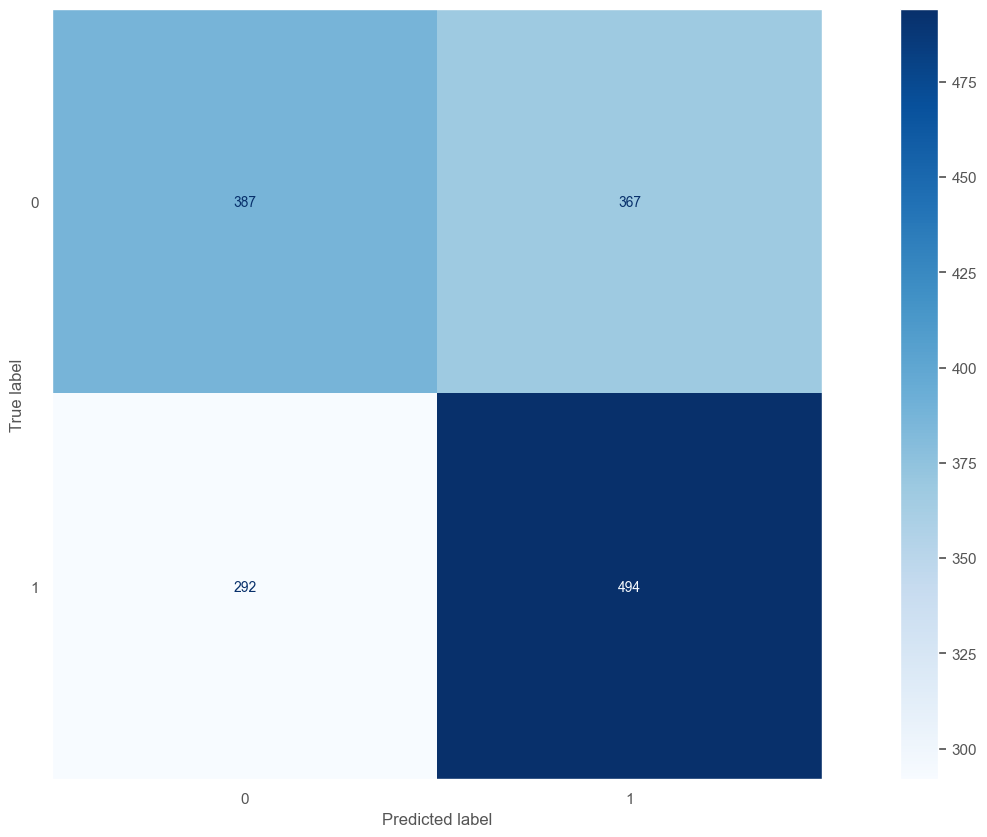

In [166]:
pipeline = Pipeline([
    ('xgb', xgb.XGBClassifier(max_depth=1, n_estimators=5, random_state=42))  
])

pipeline.fit(X_train_flat, labels_train)

print("Tuned model:")
print(classification_report(labels_train, pipeline.predict(X_train_flat)))
disp = ConfusionMatrixDisplay.from_estimator(
        pipeline,
        X_train_flat,
        labels_train,
        display_labels=pipeline.classes_,
        cmap=plt.cm.Blues
    )
disp.ax_.grid(False)

scores = cross_val_score(pipeline, X_train_flat, labels_train, cv=tscv, scoring=fb_score)
print(scores.mean(), scores.std())

Tuned model:
              precision    recall  f1-score   support

           0       0.58      0.52      0.54       754
           1       0.58      0.64      0.61       786

    accuracy                           0.58      1540
   macro avg       0.58      0.58      0.58      1540
weighted avg       0.58      0.58      0.58      1540

0.5502733775632638 0.08801015036025313


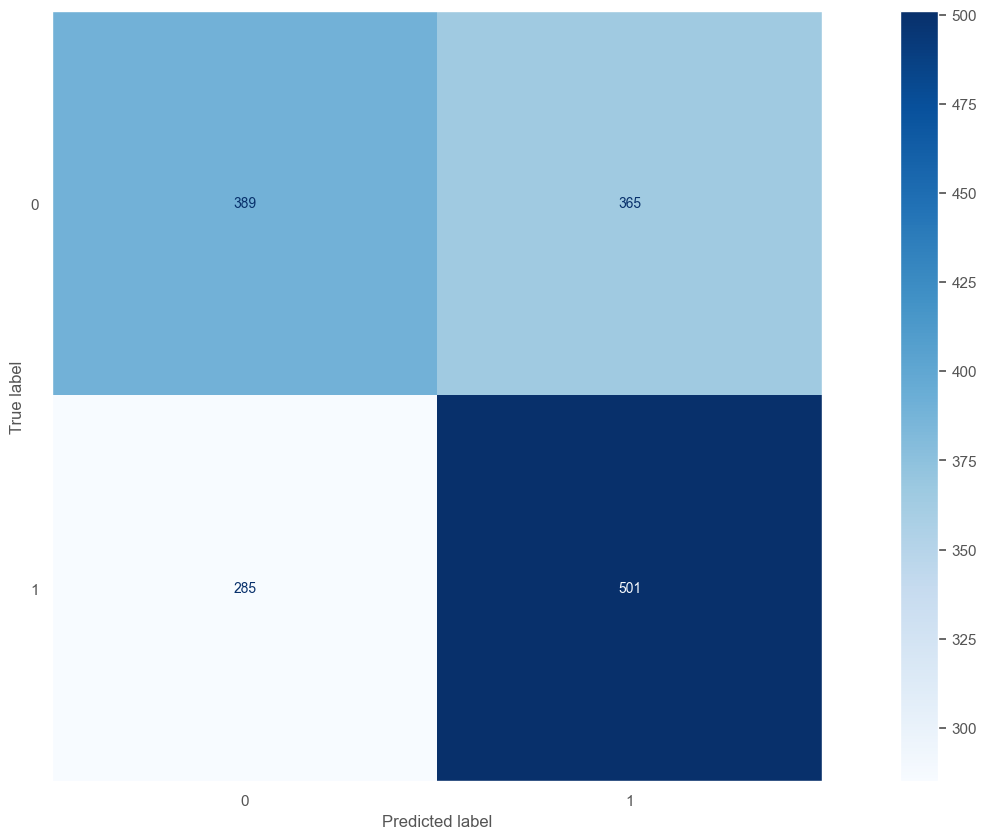

In [164]:
pipeline = Pipeline([
    ('rf', RandomForestClassifier(max_depth=2, n_estimators=500, random_state=42))  # SVM classifier
])

pipeline.fit(X_train_flat, labels_train)

print("Tuned model:")
print(classification_report(labels_train, pipeline.predict(X_train_flat)))
disp = ConfusionMatrixDisplay.from_estimator(
        pipeline,
        X_train_flat,
        labels_train,
        display_labels=pipeline.classes_,
        cmap=plt.cm.Blues
    )
disp.ax_.grid(False)

scores = cross_val_score(pipeline, X_train_flat, labels_train, cv=tscv, scoring=fb_score)
print(scores.mean(), scores.std())

In [142]:
tscv = TimeSeriesSplit(n_splits=5, gap=1)
pipeline_cv = Pipeline([
    ('svm', SVC())  # SVM classifier
])
param_grid_svm = [{'svm__C':[0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 2.5, 5, 10.0],
                   'svm__kernel':['rbf'],
                   'svm__gamma':["scale", "auto", 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1]}]
grid_search = GridSearchCV(pipeline_cv, param_grid_svm, n_jobs=-1, cv=tscv, scoring=fb_score)
grid_search.fit(X_train_flat, labels_train)
grid_search.best_params_

{'svm__C': 1.0, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}

Tuned model:
              precision    recall  f1-score   support

           0       0.56      0.42      0.48       754
           1       0.55      0.69      0.61       786

    accuracy                           0.56      1540
   macro avg       0.56      0.55      0.55      1540
weighted avg       0.56      0.56      0.55      1540

0.5215341598583136 0.062367999496191054


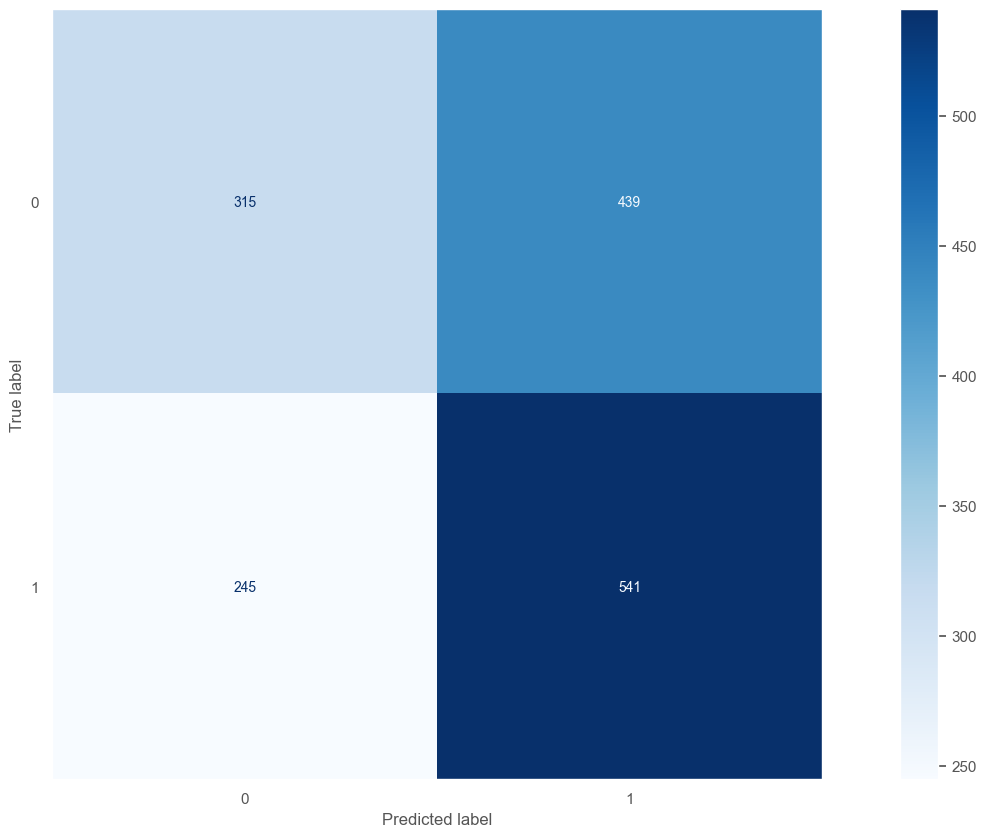

In [152]:
pipeline = Pipeline([
    ('svm', SVC(C=2.5, gamma='auto', kernel='rbf'))  # SVM classifier
])

pipeline.fit(X_train_flat, labels_train)

print("Tuned model:")
print(classification_report(labels_train, pipeline.predict(X_train_flat)))
disp = ConfusionMatrixDisplay.from_estimator(
        pipeline,
        X_train_flat,
        labels_train,
        display_labels=pipeline.classes_,
        cmap=plt.cm.Blues
    )
disp.ax_.grid(False)

scores = cross_val_score(pipeline, X_train_flat, labels_train, cv=tscv, scoring=fb_score)
print(scores.mean(), scores.std())

In [34]:
list(feature_scores[feature_scores > 0.1].index)

['pct_CVIX1I Index']

In [49]:
selected_features = strong_support# + weak_support
#selected_features = list(feature_scores[feature_scores > 0.1].index)
#selected_features = ['pct_CVIX1I Index', 'pct_spread_realised_par']
X_train_flat = X_train_flat[selected_features]
X_test_flat = X_test_flat[selected_features]

In [40]:
models = [LogisticRegression(), LinearSVC(), SVC(), RandomForestClassifier(), KNeighborsClassifier()]
for m in models:
    m.fit(X_train_flat, labels_train)
    scores = cross_val_score(m, X_train_flat, labels_train, cv=tscv, scoring=fb_score)
    print(m, scores.mean(), scores.std())

LogisticRegression() 0.5245973629732179 0.09523468686833476
LinearSVC() 0.517935706778214 0.09353927069853353


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.

/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.

/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.

/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.

/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will 

SVC() 0.4986594338814885 0.07965685685965407
RandomForestClassifier() 0.509704657878542 0.06390636691637372
KNeighborsClassifier() 0.5133684131125896 0.1068488679436191


In [463]:
models = [LogisticRegression(random_state=42), RandomForestClassifier(max_depth=2, n_estimators=50, random_state=42),
          SVC(C=1, gamma=0.1, kernel='rbf', random_state=42), LinearSVC(C=0.01), KNeighborsClassifier(n_neighbors=5, weights='distance')]
for model in models:
    cross_val_test = np.array([])
    cross_val_pred = np.array([])
    scores = np.array([])
    for train, test in tscv.split(X_train_flat):
        model.fit(X_train_flat.iloc[train], labels_train.iloc[train])
        cross_val_test = np.append(cross_val_test, labels_train.iloc[test])
        cross_val_pred = np.append(cross_val_pred, model.predict(X_train_flat.iloc[test]))
        scores = np.append(scores, fbeta_score(labels_train.iloc[test], model.predict(X_train_flat.iloc[test]), beta=0.25))
    print(model)
    print(classification_report(cross_val_test, cross_val_pred))
    print(confusion_matrix(cross_val_test, cross_val_pred))
    print('Mean score:', scores.mean())
    print('Std score:', scores.std())

LogisticRegression(random_state=42)
              precision    recall  f1-score   support

         0.0       0.53      0.48      0.50       630
         1.0       0.54      0.59      0.57       650

    accuracy                           0.54      1280
   macro avg       0.54      0.54      0.53      1280
weighted avg       0.54      0.54      0.54      1280

[[301 329]
 [264 386]]
Mean score: 0.561150181680966
Std score: 0.08257202239731876
RandomForestClassifier(max_depth=2, n_estimators=50, random_state=42)
              precision    recall  f1-score   support

         0.0       0.50      0.52      0.51       630
         1.0       0.51      0.49      0.50       650

    accuracy                           0.51      1280
   macro avg       0.51      0.51      0.51      1280
weighted avg       0.51      0.51      0.51      1280

[[330 300]
 [332 318]]
Mean score: 0.5322577689766095
Std score: 0.09004885258858672
SVC(C=1, gamma=0.1, random_state=42)
              precision    recall 

In [464]:
voting_model = VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                                            #('rf', RandomForestClassifier(max_depth=2, n_estimators=100, random_state=42)),
                                            ('svc', SVC(C=1, gamma=0.1, kernel='rbf', random_state=42, probability=True)),
                                            ('lsvc', LinearSVC(C=0.01))],
                                            #('knn', KNeighborsClassifier(n_neighbors=75, weights='distance'))],
                                            voting='hard')
cross_val_test = np.array([])
cross_val_pred = np.array([])
scores = np.array([])
for train, test in tscv.split(X_train_flat):
    voting_model.fit(X_train_flat.iloc[train], labels_train.iloc[train])
    cross_val_test = np.append(cross_val_test, labels_train.iloc[test])
    cross_val_pred = np.append(cross_val_pred, voting_model.predict(X_train_flat.iloc[test]))
    scores = np.append(scores, fbeta_score(labels_train.iloc[test], voting_model.predict(X_train_flat.iloc[test]), beta=0.25))
print(classification_report(cross_val_test, cross_val_pred))
print(confusion_matrix(cross_val_test, cross_val_pred))
print('Mean score:', scores.mean())
print('Std score:', scores.std())

              precision    recall  f1-score   support

         0.0       0.54      0.47      0.50       630
         1.0       0.54      0.61      0.57       650

    accuracy                           0.54      1280
   macro avg       0.54      0.54      0.54      1280
weighted avg       0.54      0.54      0.54      1280

[[296 334]
 [255 395]]
Mean score: 0.566988786954331
Std score: 0.08079060884118792


              precision    recall  f1-score   support

           0       0.55      0.45      0.50       754
           1       0.55      0.65      0.60       786

    accuracy                           0.55      1540
   macro avg       0.55      0.55      0.55      1540
weighted avg       0.55      0.55      0.55      1540



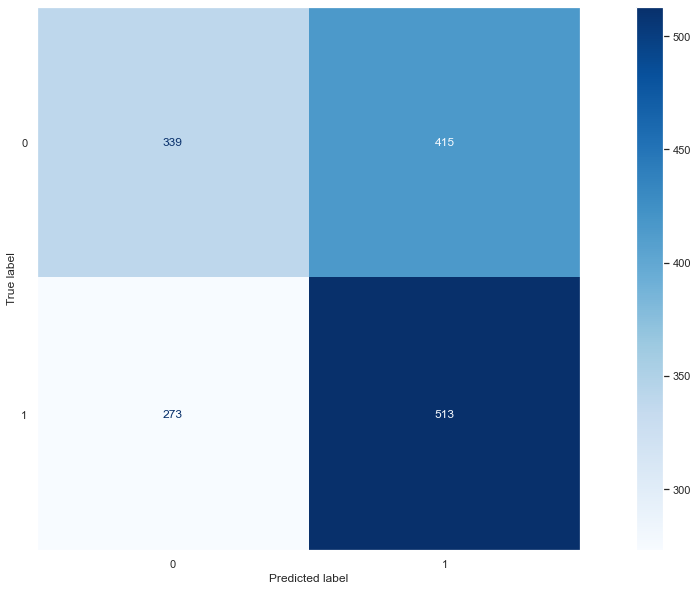

In [465]:
clf = voting_model
clf.fit(X_train_flat, labels_train)
print(classification_report(labels_train, clf.predict(X_train_flat)))
disp = ConfusionMatrixDisplay.from_estimator(
        clf,
        X_train_flat,
        labels_train,
        display_labels=pipeline.classes_,
        cmap=plt.cm.Blues
    )
disp.ax_.grid(False)

In [383]:
des_vector = voting_model.predict_proba(X_train_flat)[:,1]
des_th = np.percentile(des_vector[des_vector > 0.5], 20)
print(classification_report(labels_train, (voting_model.predict_proba(X_train_flat)[:,1]>des_th).astype(int)))

              precision    recall  f1-score   support

           0       0.56      0.60      0.58       754
           1       0.59      0.54      0.56       786

    accuracy                           0.57      1540
   macro avg       0.57      0.57      0.57      1540
weighted avg       0.57      0.57      0.57      1540



In [459]:
param_grid = {"C":[0.01, 0.1, 1, 10]}

rf_model = GridSearchCV(LinearSVC(random_state=42), 
                        param_grid, n_jobs=-1, cv=tscv, scoring='precision')
rf_model.fit(X_train_flat, labels_train)
rf_model.best_params_

{'C': 0.01}

In [460]:
param_grid = {"n_estimators":[10, 50, 100, 500],
              "max_depth":[2, 3, 4, 5]}

rf_model = GridSearchCV(RandomForestClassifier(random_state=42), 
                        param_grid, n_jobs=-1, cv=tscv, scoring='precision')
rf_model.fit(X_train_flat, labels_train)
rf_model.best_params_

{'max_depth': 2, 'n_estimators': 50}

0.5542484189496562
0.5884493895154596
              precision    recall  f1-score   support

           0       0.60      0.50      0.55       754
           1       0.59      0.68      0.63       786

    accuracy                           0.59      1540
   macro avg       0.59      0.59      0.59      1540
weighted avg       0.59      0.59      0.59      1540

Cross Validation ROC-AUC average: 0.533
Cross Validation ROC-AUC std: 0.094


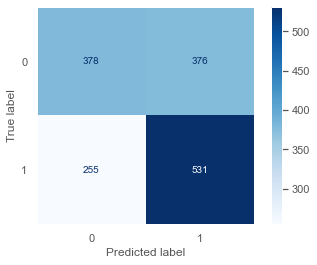

In [387]:
bm_model = LogisticRegression(random_state=42)
bm_model.fit(X_train_flat, labels_train)
print(roc_auc_score(labels_train, bm_model.predict(X_train_flat)))
rf_model = RandomForestClassifier(max_depth=2, n_estimators=100, random_state=42)
rf_model.fit(X_train_flat, labels_train)
print(roc_auc_score(labels_train, rf_model.predict(X_train_flat)))
print(classification_report(labels_train, rf_model.predict(X_train_flat)))
scores = cross_val_score(rf_model, X_train_flat, labels_train, n_jobs=-1,
                         scoring='precision', cv=tscv)
print("Cross Validation ROC-AUC average: %.3f" % scores.mean())
print("Cross Validation ROC-AUC std: %.3f" % scores.std())
disp = ConfusionMatrixDisplay.from_estimator(
        rf_model,
        X_train_flat,
        labels_train,
        display_labels=pipeline.classes_,
        cmap=plt.cm.Blues
    )
disp.ax_.grid(False)

In [388]:
des_vector = rf_model.predict_proba(X_train_flat)[:,1]
des_th = np.percentile(des_vector[des_vector > 0.5], 20)
print(classification_report(labels_train, (rf_model.predict_proba(X_train_flat)[:,1]>des_th).astype(int)))


              precision    recall  f1-score   support

           0       0.57      0.62      0.60       754
           1       0.60      0.56      0.58       786

    accuracy                           0.59      1540
   macro avg       0.59      0.59      0.59      1540
weighted avg       0.59      0.59      0.59      1540



In [461]:
tscv = TimeSeriesSplit(n_splits=5, gap=1)
pipeline_cv = Pipeline([
    ('svm', SVC())  # SVM classifier
])
param_grid_svm = [{'svm__C':[0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 2.5, 5],
                   'svm__kernel':['rbf'],
                   'svm__gamma':["scale", "auto", 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1]}]
grid_search = GridSearchCV(pipeline_cv, param_grid_svm, n_jobs=-1, cv=tscv, scoring='precision')
grid_search.fit(X_train_flat, labels_train)
grid_search.best_params_

{'svm__C': 1.0, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}

Tuned model:
              precision    recall  f1-score   support

           0       0.56      0.42      0.48       754
           1       0.55      0.69      0.61       786

    accuracy                           0.56      1540
   macro avg       0.56      0.55      0.55      1540
weighted avg       0.56      0.56      0.55      1540

Cross Validation ROC-AUC average: 0.525
Cross Validation ROC-AUC std: 0.067


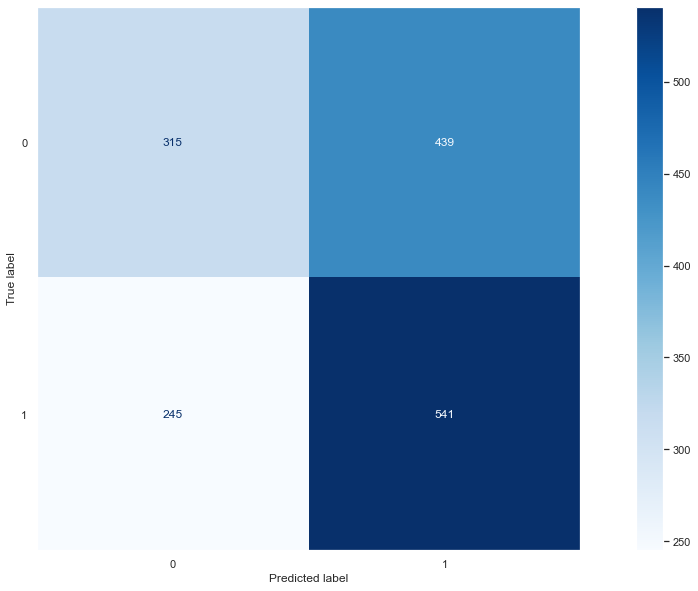

In [485]:
pipeline = Pipeline([
    ('svm', SVC(C=2.5, gamma='auto', kernel='rbf'))  # SVM classifier
])

pipeline.fit(X_train_flat, labels_train)

print("Tuned model:")
print(classification_report(labels_train, pipeline.predict(X_train_flat)))

scores = cross_val_score(pipeline, X_train_flat, labels_train, n_jobs=-1,
                         scoring='precision', cv=tscv)
print("Cross Validation ROC-AUC average: %.3f" % scores.mean())
print("Cross Validation ROC-AUC std: %.3f" % scores.std())
disp = ConfusionMatrixDisplay.from_estimator(
        pipeline,
        X_train_flat,
        labels_train,
        display_labels=pipeline.classes_,
        cmap=plt.cm.Blues
    )
disp.ax_.grid(False)

In [167]:
des_vector = pipeline.decision_function(X_train_flat)
des_th = np.percentile(des_vector[des_vector > 0], 25)
print(classification_report(labels_train, pipeline.decision_function(X_train_flat) > des_th))

AttributeError: 'XGBClassifier' object has no attribute 'decision_function'

In [154]:
print(classification_report(labels_test, pipeline.decision_function(X_test_flat[X_train_flat.columns]) > des_th))

              precision    recall  f1-score   support

           0       0.54      0.47      0.50       217
           1       0.42      0.49      0.45       168

    accuracy                           0.48       385
   macro avg       0.48      0.48      0.48       385
weighted avg       0.49      0.48      0.48       385



In [169]:
print(classification_report(labels_test, (xgb_model.predict_proba(X_test_flat[X_train_flat.columns])[:,1]>0.5).astype(int)))


              precision    recall  f1-score   support

           0       0.49      0.34      0.40       217
           1       0.39      0.54      0.45       168

    accuracy                           0.43       385
   macro avg       0.44      0.44      0.43       385
weighted avg       0.45      0.43      0.42       385



In [483]:
((pipeline.decision_function(X_test_flat) > des_th).astype(int) * y_test_flat).cumsum().iplot()

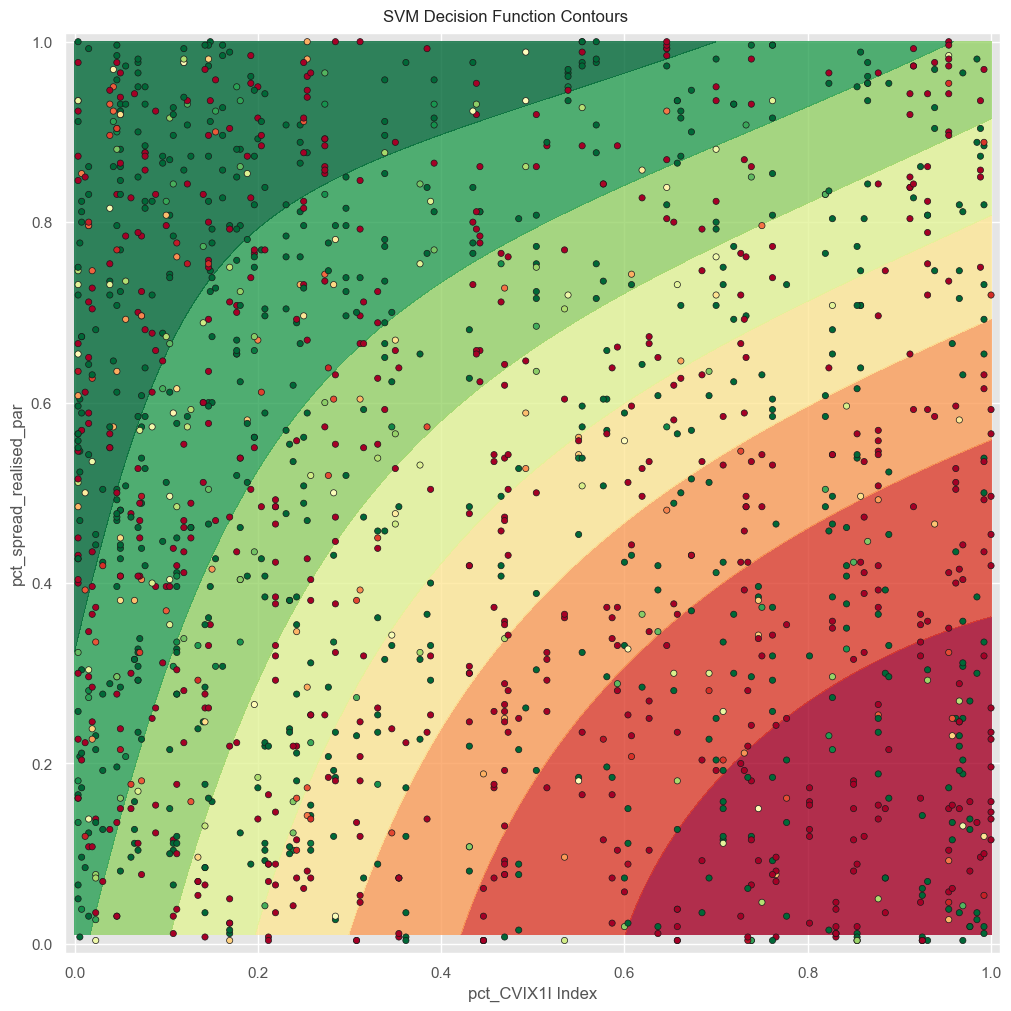

In [155]:
xx, yy = np.meshgrid(np.arange(0,1.01,0.01), np.arange(0.01,1.01,0.01))
fig, ax = plt.subplots(figsize=(10,10), constrained_layout=True)
plot_contours(ax, pipeline, xx, yy, cmap='RdYlGn', vmin=-1, vmax=1, alpha=0.8)
ax.scatter(X_train_flat.iloc[:,0], X_train_flat.iloc[:,1],
        c=y_train_flat, cmap='RdYlGn', vmin=0, vmax=1, s=20, edgecolors='k')
plt.xlim(-0.01,1.01)
plt.ylim(-0.01,1.01)
ax.xaxis.set_label_text(X_train_flat.columns[0])
ax.yaxis.set_label_text(X_train_flat.columns[1])
fig.suptitle('SVM Decision Function Contours')
fig.show()